In [189]:
!pip install plotly
!pip install cufflinks
!pip install squarify

## Importação de bibliotecas

In [190]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
from functools import reduce
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import squarify

In [191]:
# Habilitando conexão com google drive
#from google.colab import drive
#drive.mount('/content/drive')

## Leitura dos arquivos de dados

In [192]:
filesList = []

#Laço para percorrer o diretório e ler todos os arquivos csv
for dirname, _, filenames in os.walk('/home/paula/curso/olist/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
       
        file = os.path.join(dirname, filename)
        #Padronizando o nome, pegando o texto diretamente depois do endereço alocado (34 caracteres), retirando os 12 caracteres finais
        fileExt = file[34:-12] 
 
        #Lendo cada arquivo com o pandas e seus respectivos nomes
        exec('data_{:s} = pd.read_csv("{:s}")'.format(fileExt, file)) 
        
        #Alimentando a lista de arquivos
        filesList.append('data_{:s}'.format(fileExt))

filesList

/home/paula/curso/olist/data/olist_order_reviews_dataset.csv
/home/paula/curso/olist/data/olist_order_items_dataset.csv
/home/paula/curso/olist/data/olist_order_payments_dataset.csv
/home/paula/curso/olist/data/olist_customers_dataset.csv
/home/paula/curso/olist/data/olist_orders_dataset.csv
/home/paula/curso/olist/data/olist_products_dataset.csv


['data__order_reviews',
 'data__order_items',
 'data__order_payments',
 'data__customers',
 'data__orders',
 'data__products']

## Verificação e tratamento de dados

In [193]:
data__order_items.shape

(112650, 7)

In [194]:
#Excluindo campos desnecessários para a EDA
data__order_items.isnull().sum()
data__order_items.drop(['seller_id'],axis=1,inplace=True)
data__order_items.drop(['shipping_limit_date'],axis=1,inplace=True)
data__order_items.sample(15)

order_id  order_item_id  \
27541   3ea393b6b5c82e62aadb0bab29892bbf              2   
34924   4f1330720e5aa2d61a474c63620fc42b              1   
45522   67657701feeda0e62f6364ab7d3add38              1   
97844   ddefab02557da340a3bc73518bf2ecf4              1   
46122   68b1551079ac4d4fb25abea8c47fbfa8              1   
17845   28e9ee43938891c706c6c9e8ce21d0ec              1   
104809  ee116eb6355020a3addabb2a821ec818              1   
34496   4e022ead5e2400d39b29402c979aa681              5   
10469   17f11cd471c4f712a82d85c589119638              1   
38310   56fcb6d24acb1b94dd4492f663187b69              1   
84476   bfea49050a2776e89546f0925b44c4dd              1   
98775   e01023596310bc78e2726329569e3d21              1   
66555   9820cf94f2ea4678a6f6b7aa8042f20c              1   
105734  f0427cccb303a6d9c1d33af23a9f0c65              1   
34064   4d1169dbb1880a13338378683225356b              1   

                              product_id   price  freight_value  
27541   452f66a0f164cac57802e2cea93188ac   50.90           8.20  
34924   33fac76e7f17367dedaef7954bbb33b4   88.00          16.87  
45522   12827caf723c4ff8030d64dcffe3cdab   60.00           7.87  
97844   ecd15c67f7a723b7de79f4346911e122  199.90          16.50  
46122   60567eaf5cdf794639e94508ec387a82  169.99          26.03  
17845   852b4b6ded0425a736da9dd818e872b6   35.00          11.85  
104809  664e36c9f1780f33973e063ae2cdcc66   29.90          20.75  
34496   2d188e4d3435b1bf29dfd385b324de2c   52.99          12.71  
10469   9a7c6041fa9592d9d9ef6cfe62a71f8c  127.00          34.69  
38310   06649da52cbfbb4e9b6cfc332d56c119   79.90          18.44  
84476   7b453aa3584d61c1268d77ba6fd5956b  109.90          10.96  
98775   cf28a2b7bc92809a0574cf07772c88c4   24.90          11.85  
66555   3a12fe499b9342f78cb827ee18393e7f   34.99          12.69  
105734  4a0c2a56e65c941a0bb9874c47dd66d8   84.99          18.17  
34064   4d94f51353a058d28468a03ebe1aae33  225.00          60.58

In [195]:
data__order_items.isnull().sum()

order_id         0
order_item_id    0
product_id       0
price            0
freight_value    0
dtype: int64

In [196]:
#Como podermos ver, um pedido pode ter mais de um item
data__order_items.groupby('order_id').size().sort_values(ascending=False)

order_id
8272b63d03f5f79c56e9e4120aec44ef    21
1b15974a0141d54e36626dca3fdc731a    20
ab14fdcfbe524636d65ee38360e22ce8    20
9ef13efd6949e4573a18964dd1bbe7f5    15
428a2f660dc84138d969ccd69a0ab6d5    15
                                    ..
5a0911d70c1f85d3bed0df1bf693a6dd     1
5a082b558a3798d3e36d93bfa8ca1eae     1
5a07264682e0b8fbb3f166edbbffc6e8     1
5a071192a28951b76774e5a760c8c9b7     1
fffe41c64501cc87c801fd61db3f6244     1
Length: 98666, dtype: int64

In [197]:
data__order_payments.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [198]:
data__customers.isnull().sum()
data__customers.drop(['customer_zip_code_prefix'],axis=1,inplace=True)
data__customers.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

           customer_city customer_state  
0                 franca             SP  
1  sao bernardo do campo             SP  
2              sao paulo             SP  
3        mogi das cruzes             SP  
4               campinas             SP

In [199]:
#Verificando a disposição da base de dados de pedidos por status
data__orders.value_counts(data__orders['order_status'])

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
dtype: int64

In [200]:
#Para classificaçao de clientes, consideraremos apenas os produtos entregues
data__orders=data__orders.loc[data__orders['order_status']=='delivered']
data__orders['order_purchase_timestamp'] = pd.to_datetime(data__orders['order_purchase_timestamp'])
data__orders['order_estimated_delivery_date'] = pd.to_datetime(data__orders['order_estimated_delivery_date'])
data__orders['order_delivered_customer_date'] = pd.to_datetime(data__orders['order_delivered_customer_date'])
data__orders['dif_previsao_entrega']=((data__orders['order_estimated_delivery_date'])-(data__orders['order_delivered_customer_date'])).dt.days
data__orders['dif_previsao_entrega'].fillna(0,inplace=True)
data__orders.dropna(inplace=True)
data__orders.isnull().sum()
data__orders.shape


(96455, 9)

In [201]:
data__orders['dif_previsao_entrega']=data__orders['dif_previsao_entrega'].astype('int64')
data__orders.sample(10)
data__orders.loc[data__orders['dif_previsao_entrega']<0]

order_id                       customer_id  \
20     203096f03d82e0dffbc41ebc2e2bcfb7  d2b091571da224a1b36412c18bc3bbfe   
25     fbf9ac61453ac646ce8ad9783d7d0af6  3a874b4d4c4b6543206ff5d89287f0c3   
35     8563039e855156e48fccee4d611a3196  5f16605299d698660e0606f7eae2d2f9   
41     6ea2f835b4556291ffdc53fa0b3b95e8  c7340080e394356141681bd4c9b8fe31   
57     66e4624ae69e7dc89bd50222b59f581f  684fa6da5134b9e4dab731e00011712d   
...                                 ...                               ...   
99396  b3112ca67f3afd4e20cf2ee91fc4f804  6f83c71b6c044fb156d697d4130fe9b5   
99397  0fa1fab1d7c1211c824596ed5e111e3c  7f3bd6c94d2daf7b6462d1a894a775b4   
99423  38e9133ce29f6bbe35aed9c3863dce01  ad312389a098ceff46ce92c4595c06d0   
99425  d692ef54145c9cb3322ec2e5508aa3f4  82ddfcf9438b0cd1117b55ac33184df8   
99432  cfa78b997e329a5295b4ee6972c02979  a2f7428f0cafbc8e59f20e1444b67315   

      order_status order_purchase_timestamp    order_approved_at  \
20       delivered      2017-09-18 14:31:30  2017-09-19 04:04:09   
25       delivered      2018-02-20 23:46:53  2018-02-22 02:30:46   
35       delivered      2018-02-17 15:59:46  2018-02-17 16:15:34   
41       delivered      2017-11-24 21:27:48  2017-11-25 00:21:09   
57       delivered      2018-03-09 14:50:15  2018-03-09 15:40:39   
...            ...                      ...                  ...   
99396    delivered      2018-08-02 22:46:54  2018-08-02 23:04:06   
99397    delivered      2018-03-13 21:48:57  2018-03-13 22:40:28   
99423    delivered      2017-10-12 20:54:11  2017-10-14 03:28:24   
99425    delivered      2018-03-21 19:47:18  2018-03-21 20:05:26   
99432    delivered      2017-12-20 09:52:41  2017-12-20 10:09:52   

      order_delivered_carrier_date order_delivered_customer_date  \
20             2017-10-06 17:50:03           2017-10-09 22:23:46   
25             2018-02-26 22:25:22           2018-03-21 22:03:54   
35             2018-02-20 23:03:56           2018-03-20 00:59:25   
41             2017-12-13 21:14:05           2017-12-28 18:59:23   
57             2018-03-15 00:31:19           2018-04-03 13:28:46   
...                            ...                           ...   
99396          2018-08-15 17:42:00           2018-08-21 00:03:26   
99397          2018-03-14 19:27:23           2018-04-05 19:59:49   
99423          2017-10-17 17:04:42           2017-11-21 17:06:59   
99425          2018-03-22 21:11:58           2018-04-11 00:48:31   
99432          2017-12-20 20:25:25           2018-01-26 15:45:14   

      order_estimated_delivery_date  dif_previsao_entrega  
20                       2017-09-28                   -12  
25                       2018-03-12                   -10  
35                       2018-03-20                    -1  
41                       2017-12-21                    -8  
57                       2018-04-02                    -2  
...                             ...                   ...  
99396                    2018-08-16                    -6  
99397                    2018-04-02                    -4  
99423                    2017-10-31                   -22  
99425                    2018-04-09                    -3  
99432                    2018-01-18                    -9  

[7825 rows x 9 columns]

In [202]:
#Criando colunas separando as datas para análise
data__orders['ano_compra'] = data__orders['order_purchase_timestamp'].dt.year
data__orders['mes_compra'] = data__orders['order_purchase_timestamp'].dt.month
data__orders['dia_compra'] = data__orders['order_purchase_timestamp'].dt.day
data__orders['dia_semana_compra'] = data__orders['order_purchase_timestamp'].dt.weekday

In [203]:
#Deletando colunas que não serão utilizadas
data__orders.drop(['order_approved_at'],axis=1,inplace=True)
data__orders.drop(['order_delivered_carrier_date'],axis=1,inplace=True)
data__orders.drop(['order_delivered_customer_date'],axis=1,inplace=True)
data__orders.drop(['order_estimated_delivery_date'],axis=1,inplace=True)
data__orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp  dif_previsao_entrega  ano_compra  \
0    delivered      2017-10-02 10:56:33                     7        2017   
1    delivered      2018-07-24 20:41:37                     5        2018   
2    delivered      2018-08-08 08:38:49                    17        2018   
3    delivered      2017-11-18 19:28:06                    12        2017   
4    delivered      2018-02-13 21:18:39                     9        2018   

   mes_compra  dia_compra  dia_semana_compra  
0          10           2                  0  
1           7          24                  1  
2           8           8                  2  
3          11          18                  5  
4           2          13                  1

In [204]:
#Criando campos de dia da semana
name_dia = []
for d in data__orders.dia_semana_compra:
  if d == 6:
    d = 'dom'
  elif d == 0:
    d = 'seg'
  elif d == 1:
    d = 'ter'
  elif d == 2:
    d = 'qua'
  elif d == 3:
    d = 'qui'
  elif d == 4:
    d = 'sex'
  else:
    d = 'sab'
  name_dia.append(d)
data__orders['dia_semana_compra'] = name_dia
data__orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp  dif_previsao_entrega  ano_compra  \
0    delivered      2017-10-02 10:56:33                     7        2017   
1    delivered      2018-07-24 20:41:37                     5        2018   
2    delivered      2018-08-08 08:38:49                    17        2018   
3    delivered      2017-11-18 19:28:06                    12        2017   
4    delivered      2018-02-13 21:18:39                     9        2018   

   mes_compra  dia_compra dia_semana_compra  
0          10           2               seg  
1           7          24               ter  
2           8           8               qua  
3          11          18               sab  
4           2          13               ter

In [205]:
#Preenchendo valores nulos de categoria como No category para não influenciar nos itens de pedido que não tiverem categoria
data__products['product_category_name'].fillna('Não informado',inplace =True)
data__products.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

In [206]:
#Deletando colunas que não serão utilizadas
data__products.drop(['product_name_lenght'],axis=1,inplace=True)
data__products.drop(['product_photos_qty'],axis=1,inplace=True)
data__products.drop(['product_description_lenght'],axis=1,inplace=True)
data__products.drop(['product_weight_g'],axis=1,inplace=True)
data__products.drop(['product_length_cm'],axis=1,inplace=True)
data__products.drop(['product_height_cm'],axis=1,inplace=True)
data__products.drop(['product_width_cm'],axis=1,inplace=True)
data__products.head()

product_id  product_category_name
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer
3  cef67bcfe19066a932b7673e239eb23d                  bebes
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas

In [207]:
data__order_reviews.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [208]:
#Substituindo valores nulos de titulo e mensagem nos reviews
data__order_reviews['review_comment_title'].fillna('Sem Titulo',inplace =True)
data__order_reviews['review_comment_message'].fillna('Sem Mensagem',inplace =True)
#Os registros não foram excluídos pois contém notas que podem ser relevantes para a análise e classificação

In [209]:
#Deletando colunas que não serão utilizadas
data__order_reviews.drop(['review_id'],axis=1,inplace=True)
data__order_reviews.drop(['review_comment_title'],axis=1,inplace=True)
data__order_reviews.drop(['review_comment_message'],axis=1,inplace=True)
data__order_reviews.drop(['review_creation_date'],axis=1,inplace=True)
data__order_reviews.drop(['review_answer_timestamp'],axis=1,inplace=True)
data__order_reviews.head()

order_id  review_score
0  73fc7af87114b39712e6da79b0a377eb             4
1  a548910a1c6147796b98fdf73dbeba33             5
2  f9e4b658b201a9f2ecdecbb34bed034b             5
3  658677c97b385a9be170737859d3511b             5
4  8e6bfb81e283fa7e4f11123a3fb894f1             5

In [210]:
data__order_reviews.isnull().sum()

order_id        0
review_score    0
dtype: int64

In [211]:
#removendo valores com o mesmo id de pedido que estavam duplicados mantendo o último registro apenas
data__order_reviews=data__order_reviews.drop_duplicates(subset='order_id', keep='last')

In [212]:
data__products.isnull().sum()

product_id               0
product_category_name    0
dtype: int64

In [213]:
data__orders.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp  dif_previsao_entrega  ano_compra  \
0    delivered      2017-10-02 10:56:33                     7        2017   
1    delivered      2018-07-24 20:41:37                     5        2018   
2    delivered      2018-08-08 08:38:49                    17        2018   
3    delivered      2017-11-18 19:28:06                    12        2017   
4    delivered      2018-02-13 21:18:39                     9        2018   

   mes_compra  dia_compra dia_semana_compra  
0          10           2               seg  
1           7          24               ter  
2           8           8               qua  
3          11          18               sab  
4           2          13               ter

In [214]:
#Unindo datasets em um único:
data = pd.merge(data__orders,data__order_items, on='order_id',how='left')
data = pd.merge(data, data__products, on='product_id', how='left')
data = pd.merge(data, data__customers, on='customer_id', how='left')
data = pd.merge(data,data__order_reviews, on='order_id', how='left')
data = pd.merge(data,data__order_payments, on='order_id', how='left')
data.shape


(115014, 22)

In [215]:
total_arrec=sum(data['price'])
total_clientes_olist=np.size(data['customer_unique_id'])
print('O valor total arrecadado é:', total_arrec)
print('O numéro total de clientes é:', total_clientes_olist)

O valor total arrecadado é: 13810865.07001466
O numéro total de clientes é: 115014


In [216]:
data['customer_unique_id'].value_counts()

9a736b248f67d166d2fbb006bcb877c3    75
6fbc7cdadbb522125f4b27ae9dee4060    38
f9ae226291893fda10af7965268fb7f6    35
569aa12b73b5f7edeaa6f2a01603e381    26
5419a7c9b86a43d8140e2939cd2c2f7e    24
                                    ..
1496c48d8753b54d06683c408d52c621     1
517a35f625b57d7c8533adfefb2d1b98     1
8ee092d109092f3584ee910259c59a88     1
444d40d5ed5d2215271e5f82116a82f8     1
923aff16dec33ca44db15e57aa2f20ad     1
Name: customer_unique_id, Length: 93336, dtype: int64

In [217]:
ids = data["order_id"]
data[ids.isin(ids[ids.duplicated()])]

order_id                       customer_id  \
0       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2       e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
10      e69bfb5eb88e0ed6a785585b27e16dbf  31ad1d1b63eb9962463f764d4e6e0c9d   
11      e69bfb5eb88e0ed6a785585b27e16dbf  31ad1d1b63eb9962463f764d4e6e0c9d   
...                                  ...                               ...   
115004  9115830be804184b91f5c00f6f49f92d  da2124f134f5dfbce9d06f29bdb6c308   
115005  aa04ef5214580b06b10e2a378300db44  f01a6bfcc730456317e4081fe0c9940e   
115006  aa04ef5214580b06b10e2a378300db44  f01a6bfcc730456317e4081fe0c9940e   
115011  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   
115012  11c177c8e97725db2631073c19f07b62  b331b74b18dc79bcdf6532d51e1637c1   

       order_status order_purchase_timestamp  dif_previsao_entrega  \
0         delivered      2017-10-02 10:56:33                     7   
1         delivered      2017-10-02 10:56:33                     7   
2         delivered      2017-10-02 10:56:33                     7   
10        delivered      2017-07-29 11:55:02                     6   
11        delivered      2017-07-29 11:55:02                     6   
...             ...                      ...                   ...   
115004    delivered      2017-10-04 19:57:37                    17   
115005    delivered      2017-01-27 00:30:03                    37   
115006    delivered      2017-01-27 00:30:03                    37   
115011    delivered      2018-01-08 21:28:27                    20   
115012    delivered      2018-01-08 21:28:27                    20   

        ano_compra  mes_compra  dia_compra dia_semana_compra  order_item_id  \
0             2017          10           2               seg              1   
1             2017          10           2               seg              1   
2             2017          10           2               seg              1   
10            2017           7          29               sab              1   
11            2017           7          29               sab              1   
...            ...         ...         ...               ...            ...   
115004        2017          10           4               qua              2   
115005        2017           1          27               sex              1   
115006        2017           1          27               sex              1   
115011        2018           1           8               seg              1   
115012        2018           1           8               seg              2   

        ... freight_value   product_category_name  \
0       ...          8.72   utilidades_domesticas   
1       ...          8.72   utilidades_domesticas   
2       ...          8.72   utilidades_domesticas   
10      ...         19.77       moveis_escritorio   
11      ...         19.77       moveis_escritorio   
...     ...           ...                     ...   
115004  ...         36.98              brinquedos   
115005  ...         19.43            beleza_saude   
115006  ...         19.43            beleza_saude   
115011  ...         40.59  informatica_acessorios   
115012  ...         40.59  informatica_acessorios   

                      customer_unique_id customer_city customer_state  \
0       7c396fd4830fd04220f754e42b4e5bff     sao paulo             SP   
1       7c396fd4830fd04220f754e42b4e5bff     sao paulo             SP   
2       7c396fd4830fd04220f754e42b4e5bff     sao paulo             SP   
10      299905e3934e9e181bfb2e164dd4b4f8      sorocaba             SP   
11      299905e3934e9e181bfb2e164dd4b4f8      sorocaba             SP   
...                                  ...           ...            ...   
115004  c716cf2b5b86fb24257cffe9e7969df8        cuiaba             MT   
115005  e03dbdf5e56c96b106d8115ac336f47f   divinopolis             MG   
115006  e03

In [218]:
#substituindo os scores nulos pela moda
data['review_score'].fillna(5, inplace=True)
data.dropna(inplace=True)

In [219]:
sudeste = ['SP', 'RJ', 'ES','MG']
nordeste= ['MA', 'PI', 'CE', 'RN', 'PE', 'PB', 'SE', 'AL', 'BA']
norte =  ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']
centro_oeste = ['MT', 'GO', 'MS' ,'DF' ]
sul = ['SC', 'RS', 'PR']

data.loc[data['customer_state'].isin(sudeste), 'regiao_cliente'] = 'Sudeste'
data.loc[data['customer_state'].isin(nordeste), 'regiao_cliente'] = 'Nordeste'
data.loc[data['customer_state'].isin(norte), 'regiao_cliente'] = 'Norte'
data.loc[data['customer_state'].isin(centro_oeste), 'regiao_cliente'] = 'Centro-Oeste'
data.loc[data['customer_state'].isin(sul), 'regiao_cliente'] = 'Sul'

In [220]:
#Separando data da compra e horário da compra
data['data_compra']=data['order_purchase_timestamp'].dt.date
#Arredondando o horário de 30 em 30 minutos
data['hora_compra']=data['order_purchase_timestamp'].dt.round('360min')
data['hora_compra']=data['hora_compra'].dt.time
#Pegando mês e ano da compra
data['mes_e_ano_compra']=data['order_purchase_timestamp'].dt.strftime('%m-%Y')
#Deletando colunas que não serão utilizadas
data.drop(['order_purchase_timestamp'],axis=1,inplace=True)
data.sample(14)

order_id                       customer_id  \
112784  ad443601986ce3f657edcfd5069f6bcd  894f7811a3347d5c9ba32c805c51bff0   
73452   54020a69fb0d5742c110ce591ff4c120  9fbff61ec5b6f5b4baa4dedcabcc06af   
6296    b4a1c1abe13b0e2adafb21da024cef98  81aef10a9af8f93cbfbf20e884277260   
29899   3c1b7beb2a3485c3ad6b4ba2a4865466  0da4c4dfe3d09319f5f1db69f78336fc   
109974  00f251b943aba645652c7138e4716fee  3d54e262ab34438486bd0eb8bf022c2f   
95184   2de88b97e4bbf3a783afbdd55cb955e4  3334059300fd837f7bd7d68481829fb2   
56304   6e5fe7366a2e1bfbf3257dba0af1267f  5263febf1413e9a60ceb7b842008b7ef   
92567   cc93f3b0bbc28bf5e1bd3ff40b4b2666  6a7add565bee8d10537837268f674a76   
53070   b16edeb533db83f08d8f0cad09834700  39fe84e2145530fc79019017a9eb1db9   
76500   341fde35809d4cdae709b875a0040b23  5d0a1762c0f0dd867d87f1292aa74222   
55148   685ff0ec30068be51ce8745dbccdeb0b  bf937c454bbf09413b7407b1d83e64cc   
99581   55e6b6da22f9fc2e3482b436eeea7da3  cfba97fe78a7160932c18b90b3a566a9   
42449   0c4c42e7e040dc423699b1d019b684e1  595a27292ecd8550ade73b5a81236879   
76599   bb5069a1c4caa1d28fe56f4c647d23cc  f2c48cad58997d0feebf4637a312a767   

       order_status  dif_previsao_entrega  ano_compra  mes_compra  dia_compra  \
112784    delivered                     9        2018           5          17   
73452     delivered                     2        2018           2          19   
6296      delivered                    14        2017          10           2   
29899     delivered                     7        2017           8          28   
109974    delivered                    13        2018           8          13   
95184     delivered                     4        2018           1          12   
56304     delivered                    49        2016          10           9   
92567     delivered                    18        2017          12          22   
53070     delivered                     7        2017           6          19   
76500     delivered                    14        2017          11           2   
55148     delivered                     7        2018           1           5   
99581     delivered                    -1        2018           1          18   
42449     delivered                     6        2017          11          30   
76599     delivered                    18        2017          12           7   

       dia_semana_compra  order_item_id                        product_id  \
112784               qui              1  3350d0f553c213f918a89ce65d269417   
73452                seg              1  57e089e3103f5cda6a4ce23b77399bdb   
6296                 seg              1  150c699262a053229e89213dc9c358d2   
29899                seg              1  63bd0e7bb0fdb40cbd6777aa5c7d5a56   
109974               seg              1  35afc973633aaeb6b877ff57b2793310   
95184                sex              1  08fb1fed44ecc852b3ab9363b00d1c03   
56304                dom              3  7721582bb750762d81850267d19881c1   
92567                sex              4  f3e5c2a78b72fdc48a7c2559ff7dbbd5   
53070                seg              1  59dbefe045e850ce6df6b1fd5dce14ba   
76500                qui              1  d22625c4bd160a54f96629f139153c74   
55148                sex              1  e83371d8afd820fde9ada3e2ae12f4c4   
99581                qui              1  6ab6d9589ae19abcee458918d4779fae   
42449                qui              1  24f5af2b789d02450459312d48fc840f   
76599                qui              2  cac9e5692471a0700418aa3400b9b2b1   

        ...  customer_state  review_score payment_sequential payment_type  \
112784  ...              SP           5.0                1.0       boleto   
73452   ...              SP           5.0                1.0  credit_card   
6296    ...              SP           1.0                1.0  credit_card   
29899   ...              SP           4.0                1.0  credit_card   
109974  ...              RS           5.0                1.0  credit_card   
95184   ...              PE

In [221]:
#Reorganizando o dataset
data = data[['order_id','order_status','dia_compra','mes_compra','ano_compra','dia_semana_compra','mes_e_ano_compra','data_compra','hora_compra','payment_type','payment_sequential','payment_installments','payment_value','dif_previsao_entrega','product_id','product_category_name','order_item_id','price','freight_value','review_score','customer_id','customer_unique_id','customer_city','customer_state','regiao_cliente']]
data.head()

order_id order_status  dia_compra  mes_compra  \
0  e481f51cbdc54678b7cc49136f2d6af7    delivered           2          10   
1  e481f51cbdc54678b7cc49136f2d6af7    delivered           2          10   
2  e481f51cbdc54678b7cc49136f2d6af7    delivered           2          10   
3  53cdb2fc8bc7dce0b6741e2150273451    delivered          24           7   
4  47770eb9100c2d0c44946d9cf07ec65d    delivered           8           8   

   ano_compra dia_semana_compra mes_e_ano_compra data_compra hora_compra  \
0        2017               seg          10-2017  2017-10-02    12:00:00   
1        2017               seg          10-2017  2017-10-02    12:00:00   
2        2017               seg          10-2017  2017-10-02    12:00:00   
3        2018               ter          07-2018  2018-07-24    18:00:00   
4        2018               qua          08-2018  2018-08-08    06:00:00   

  payment_type  ...  product_category_name  order_item_id   price  \
0  credit_card  ...  utilidades_domesticas              1   29.99   
1      voucher  ...  utilidades_domesticas              1   29.99   
2      voucher  ...  utilidades_domesticas              1   29.99   
3       boleto  ...             perfumaria              1  118.70   
4  credit_card  ...             automotivo              1  159.90   

   freight_value review_score                       customer_id  \
0           8.72          4.0  9ef432eb6251297304e76186b10a928d   
1           8.72          4.0  9ef432eb6251297304e76186b10a928d   
2           8.72          4.0  9ef432eb6251297304e76186b10a928d   
3          22.76          4.0  b0830fb4747a6c6d20dea0b8c802d7ef   
4          19.22          5.0  41ce2a54c0b03bf3443c3d931a367089   

                 customer_unique_id  customer_city  customer_state  \
0  7c396fd4830fd04220f754e42b4e5bff      sao paulo              SP   
1  7c396fd4830fd04220f754e42b4e5bff      sao paulo              SP   
2  7c396fd4830fd04220f754e42b4e5bff      sao paulo              SP   
3  af07308b275d755c9edb36a90c618231      barreiras              BA   
4  3a653a41f6f9fc3d2a113cf8398680e8     vianopolis              GO   

   regiao_cliente  
0         Sudeste  
1         Sudeste  
2         Sudeste  
3        Nordeste  
4    Centro-Oeste  

[5 rows x 25 columns]

In [222]:
#Renomeando as colunas
data.rename(columns={'order_id': 'id_pedido'}, inplace = True)
data.rename(columns={'order_status': 'status_pedido'}, inplace = True)
data.rename(columns={'product_id': 'id_produto'}, inplace = True)
data.rename(columns={'product_category_name': 'categoria'}, inplace = True)
data.rename(columns={'order_item_id': 'id_item_pedido'}, inplace = True)
data.rename(columns={'payment_type': 'tipo_pagamento'}, inplace = True)
data.rename(columns={'payment_sequential': 'ordem_pagamento'}, inplace = True)
data.rename(columns={'payment_installments': 'qtd_parcelas'}, inplace = True)
data.rename(columns={'payment_value': 'total_pago'}, inplace = True)
data.rename(columns={'price': 'preço'}, inplace = True)
data.rename(columns={'freight_value': 'valor_frete'}, inplace = True)
data.rename(columns={'review_score': 'nota'}, inplace = True)
data.rename(columns={'customer_id': 'id_cliente'}, inplace = True)
data.rename(columns={'customer_city': 'cidade_cliente'}, inplace = True)
data.rename(columns={'customer_state': 'estado_cliente'}, inplace = True)


In [223]:
#Conferindo se diferentes cidades estão escritas de maneiras diferentes
data['cidade_cliente'].loc[data['cidade_cliente']=='são paulo']
data['cidade_cliente'].loc[data['cidade_cliente']=='sao paulo']



0         sao paulo
1         sao paulo
2         sao paulo
14        sao paulo
16        sao paulo
            ...    
114977    sao paulo
114982    sao paulo
114983    sao paulo
114997    sao paulo
115007    sao paulo
Name: cidade_cliente, Length: 18161, dtype: object

In [224]:
data.describe()

dia_compra     mes_compra     ano_compra  ordem_pagamento  \
count  115011.000000  115011.000000  115011.000000    115011.000000   
mean       15.549930       6.033562    2017.540983         1.090704   
std         8.667038       3.227591       0.504062         0.684430   
min         1.000000       1.000000    2016.000000         1.000000   
25%         8.000000       3.000000    2017.000000         1.000000   
50%        16.000000       6.000000    2018.000000         1.000000   
75%        23.000000       8.000000    2018.000000         1.000000   
max        31.000000      12.000000    2018.000000        26.000000   

        qtd_parcelas     total_pago  dif_previsao_entrega  id_item_pedido  \
count  115011.000000  115011.000000         115011.000000   115011.000000   
mean        2.936989     171.918390             11.041083        1.196407   
std         2.772532     266.133022             10.160149        0.699425   
min         0.000000       0.000000           -189.000000        1.000000   
25%         1.000000      60.850000              6.000000        1.000000   
50%         2.000000     108.190000             12.000000        1.000000   
75%         4.000000     188.940000             16.000000        1.000000   
max        24.000000   13664.080000            146.000000       21.000000   

               preço    valor_frete           nota  
count  115011.000000  115011.000000  115011.000000  
mean      120.081819      19.996013       4.087957  
std       183.043451      15.744668       1.344328  
min         0.850000       0.000000       1.000000  
25%        39.900000      13.080000       4.000000  
50%        74.900000      16.280000       5.000000  
75%       133.000000      21.180000       5.000000  
max      6735.000000     409.680000       5.000000

In [225]:
data.shape

(115011, 25)

In [226]:
#Informações da base
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115011 entries, 0 to 115013
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id_pedido             115011 non-null  object 
 1   status_pedido         115011 non-null  object 
 2   dia_compra            115011 non-null  int64  
 3   mes_compra            115011 non-null  int64  
 4   ano_compra            115011 non-null  int64  
 5   dia_semana_compra     115011 non-null  object 
 6   mes_e_ano_compra      115011 non-null  object 
 7   data_compra           115011 non-null  object 
 8   hora_compra           115011 non-null  object 
 9   tipo_pagamento        115011 non-null  object 
 10  ordem_pagamento       115011 non-null  float64
 11  qtd_parcelas          115011 non-null  float64
 12  total_pago            115011 non-null  float64
 13  dif_previsao_entrega  115011 non-null  int64  
 14  id_produto            115011 non-null  object 
 15  

In [227]:
#Verificação de valores únicos
data.nunique().sort_values(ascending=False)

id_pedido               96454
id_cliente              96454
customer_unique_id      93335
id_produto              32210
total_pago              28543
valor_frete              6924
preço                    5859
cidade_cliente           4085
data_compra               611
dif_previsao_entrega      198
categoria                  74
dia_compra                 31
estado_cliente             27
ordem_pagamento            26
qtd_parcelas               24
mes_e_ano_compra           22
id_item_pedido             21
mes_compra                 12
dia_semana_compra           7
nota                        5
regiao_cliente              5
tipo_pagamento              4
hora_compra                 4
ano_compra                  3
status_pedido               1
dtype: int64

In [228]:
#Verificação de valores faltantes
(data.isnull().sum().sort_values(ascending=False)[:12])

id_pedido               0
dif_previsao_entrega    0
estado_cliente          0
cidade_cliente          0
customer_unique_id      0
id_cliente              0
nota                    0
valor_frete             0
preço                   0
id_item_pedido          0
categoria               0
id_produto              0
dtype: int64

# Análise Exploratória

##Distribução dos Dados

array([[<AxesSubplot:title={'center':'dia_compra'}>,
        <AxesSubplot:title={'center':'mes_compra'}>,
        <AxesSubplot:title={'center':'ano_compra'}>],
       [<AxesSubplot:title={'center':'ordem_pagamento'}>,
        <AxesSubplot:title={'center':'qtd_parcelas'}>,
        <AxesSubplot:title={'center':'total_pago'}>],
       [<AxesSubplot:title={'center':'dif_previsao_entrega'}>,
        <AxesSubplot:title={'center':'id_item_pedido'}>,
        <AxesSubplot:title={'center':'preço'}>],
       [<AxesSubplot:title={'center':'valor_frete'}>,
        <AxesSubplot:title={'center':'nota'}>, <AxesSubplot:>]],
      dtype=object)

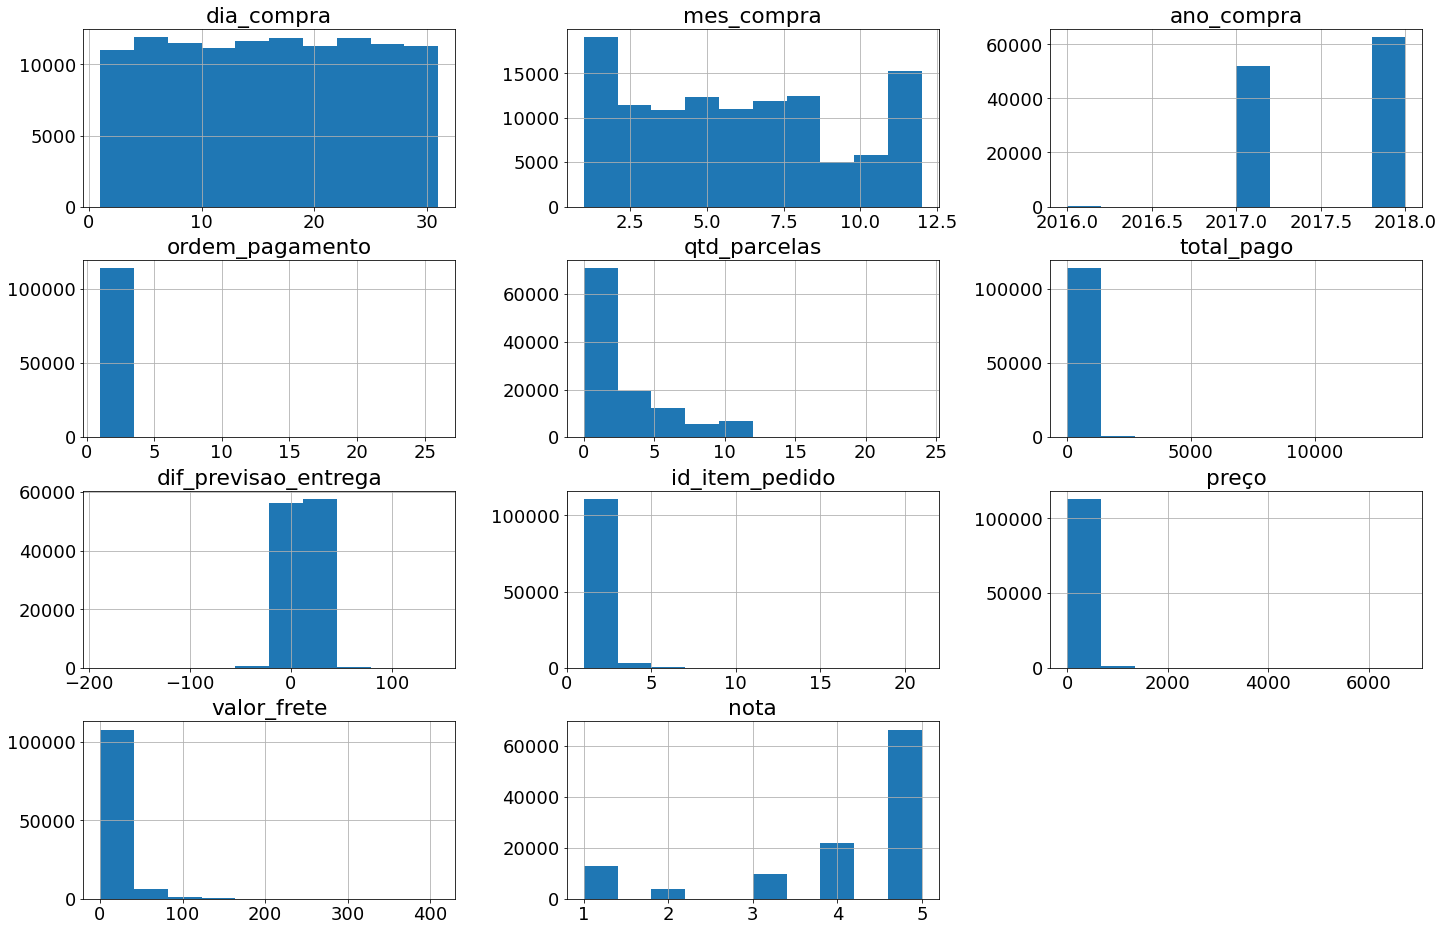

In [229]:
data.hist(figsize=(24, 16))

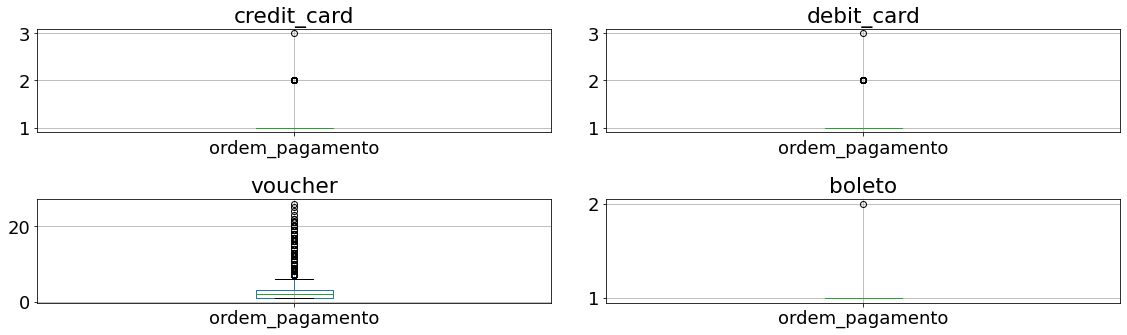

In [230]:
fig = plt.figure(figsize = (16,5))

ax1 = fig.add_subplot(2,2,1)
ax1 = data[data['tipo_pagamento']=='credit_card'].boxplot(column=['ordem_pagamento'])
ax1.set(title='credit_card')

ax2 = fig.add_subplot(2,2,2)
ax2 = data[data['tipo_pagamento']=='debit_card'].boxplot(column=['ordem_pagamento'])
ax2.set(title='debit_card')

ax3 = fig.add_subplot(2,2,3)
ax3 = data[data['tipo_pagamento']=='voucher'].boxplot(column=['ordem_pagamento'])
ax3.set(title='voucher')

ax4 = fig.add_subplot(2,2,4)
ax4 = data[data['tipo_pagamento']=='boleto'].boxplot(column=['ordem_pagamento'])
ax4.set(title='boleto')


plt.tight_layout()
plt.show()

In [231]:
data['tipo_pagamento'].value_counts()

credit_card    84888
boleto         22347
voucher         6123
debit_card      1653
Name: tipo_pagamento, dtype: int64

Analisando os dados, percebemos que os valores discrepantes para a feature tipo_pagamento é por causa dos pagamentos via voucher. 

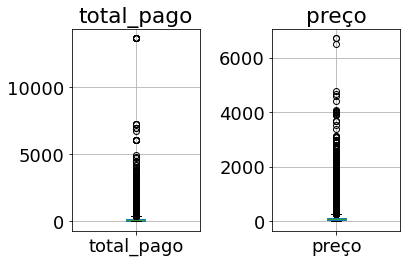

In [232]:
fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
ax1 = data.boxplot(column=['total_pago'])
ax1.set(title='total_pago')

ax2 = fig.add_subplot(1,2,2)
ax2 = data.boxplot(column=['preço'])
ax2.set(title='preço')

plt.tight_layout()
plt.show()

In [233]:
data[['total_pago','preço']].describe()

total_pago          preço
count  115011.000000  115011.000000
mean      171.918390     120.081819
std       266.133022     183.043451
min         0.000000       0.850000
25%        60.850000      39.900000
50%       108.190000      74.900000
75%       188.940000     133.000000
max     13664.080000    6735.000000

In [234]:
print(data[data['preço']>3000].shape)

(28, 25)


In [235]:
data = data[data['preço']<=3000]
data[['total_pago','preço']].describe()

total_pago          preço
count  114983.000000  114983.000000
mean      171.036772     119.118769
std       258.994284     171.611137
min         0.000000       0.850000
25%        60.850000      39.900000
50%       108.160000      74.900000
75%       188.905000     133.000000
max     13664.080000    2999.990000

Observando a distribuição dos dados da variável prço, identificamos a presença de outiliers. Com isso, definimos eliminar preços maiores que 3k

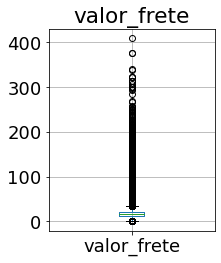

In [236]:
fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
ax1 = data.boxplot(column=['valor_frete'])
ax1.set(title='valor_frete')

plt.tight_layout()
plt.show()

In [237]:
data.valor_frete.describe()

count    114983.000000
mean         19.969445
std          15.615797
min           0.000000
25%          13.080000
50%          16.280000
75%          21.170000
max         409.680000
Name: valor_frete, dtype: float64

In [238]:
print(data[data['valor_frete']>200].shape)

(63, 25)


In [239]:
data = data[data['valor_frete']<=200]
data[['valor_frete','total_pago']].describe()

valor_frete     total_pago
count  114920.000000  114920.000000
mean       19.837798     170.332946
std        14.527941     256.649872
min         0.000000       0.000000
25%        13.080000      60.850000
50%        16.280000     108.100000
75%        21.150000     188.690000
max       196.940000   13664.080000

Observando a distribuição dos dados da variável frete, identificamos a presença de outiliers. Com isso, definimos eliminar fretes maiores que 200

In [240]:
data.shape

(114920, 25)

## Como é a distribuição dos tipos de pagamento?

In [241]:
totalPedidosTipoPagamento = data.groupby('tipo_pagamento')['id_pedido'].nunique().sort_values(ascending=False).reset_index()
totalPedidosTipoPagamento 

tipo_pagamento  id_pedido
0    credit_card      74240
1         boleto      19159
2        voucher       3678
3     debit_card       1482

(0.0, 81664.0)

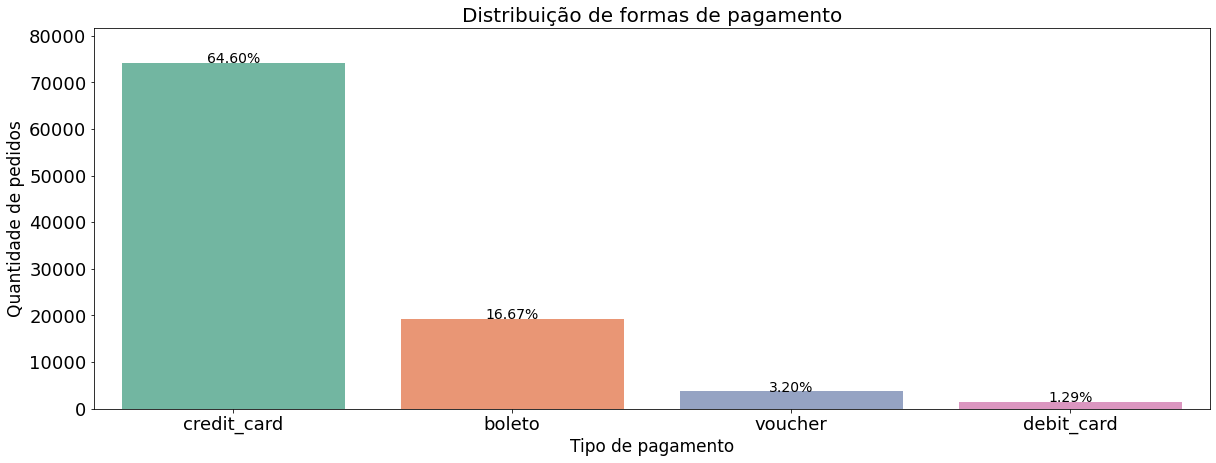

In [242]:
plt.figure(figsize=(20,7))
#sns.countplot(x='tipo_pagamento', data=data, palette='Set2')
plt.subplot(111)

total = len(data)
g = sns.barplot(x=totalPedidosTipoPagamento['tipo_pagamento'], y=totalPedidosTipoPagamento['id_pedido'], data=totalPedidosTipoPagamento, palette='Set2')
g.set_title("Distribuição de formas de pagamento", fontsize=20)
g.set_xlabel("Tipo de pagamento", fontsize=17)
g.set_ylabel("Quantidade de pedidos", fontsize=17)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.1)

(0.0, 52294.00000000001)

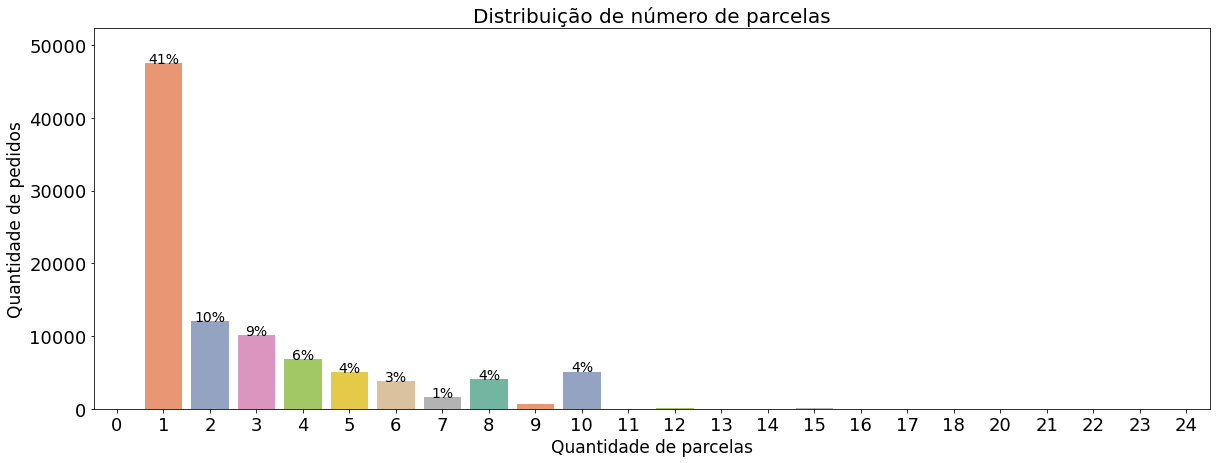

In [243]:
plt.figure(figsize=(20,7))
#sns.countplot(x='tipo_pagamento', data=data, palette='Set2')
plt.subplot(111)

totalQtdParcelas = data.groupby('qtd_parcelas')['id_pedido'].nunique().sort_values(ascending=False)
totalQtdParcelas=pd.DataFrame(totalQtdParcelas.reset_index())
totalQtdParcelas['qtd_parcelas']=totalQtdParcelas['qtd_parcelas'].astype('int64')
g = sns.barplot(x='qtd_parcelas', y='id_pedido', data=totalQtdParcelas, palette='Set2')
g.set_title("Distribuição de número de parcelas", fontsize=20)
g.set_xlabel("Quantidade de parcelas", fontsize=17)
g.set_ylabel("Quantidade de pedidos", fontsize=17)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    if (height/total*100) > 1 :
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.0f}%'.format(height/total*100),
                ha="center", fontsize=14) 
    else:
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,' ')
g.set_ylim(0, max(sizes) * 1.1)

Mais de 60% dos pedidos entregues foram pagos utilizando como método de pagamento o cartão de crédito. E cerca de 40% dos pedidos foram pagos em apenas uma parcela.

## Qual a categoria de produtos mais rentável do período analisado?

Text(0.5, 1.0, 'Top 10 categorias com mais pedidos')

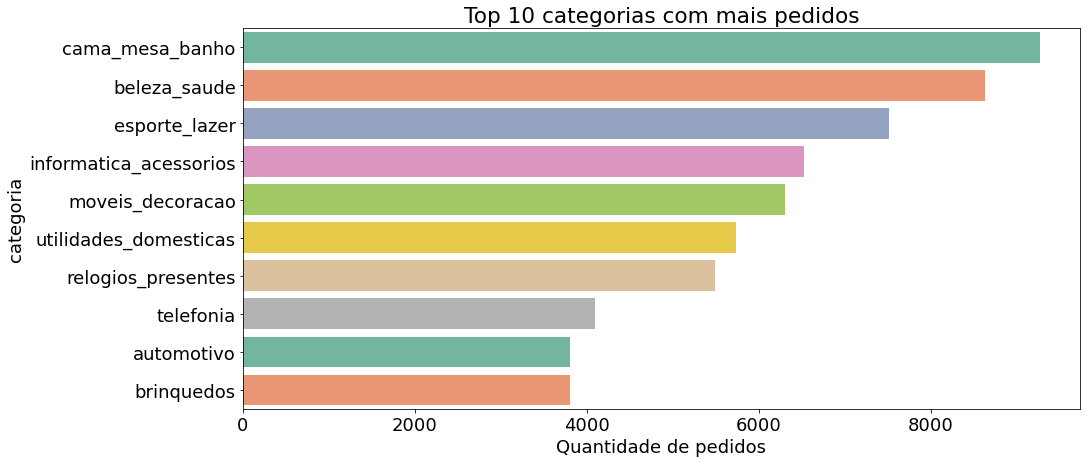

In [244]:
produtos_mais_vendidos = data.groupby('categoria')['id_pedido'].nunique().sort_values(ascending=False).head(10)
produtos_mais_vendidos

#produtos_mais_vendidos = data['categoria'].value_counts().head(10)

plt.figure(figsize=(15,7))


sns.barplot(y=produtos_mais_vendidos.index, x=produtos_mais_vendidos, palette="Set2")
plt.xlabel('Quantidade de pedidos')
plt.title('Top 10 categorias com mais pedidos')

## Existe sazonalidade de vendas?

In [245]:
#Fazendo o recorte da amostragem
filtro  = data['mes_compra'].isin([1,2,3,4,5,6,7,8])
                                      
data_aux= data[filtro]
data_aux

id_pedido status_pedido  dia_compra  \
3       53cdb2fc8bc7dce0b6741e2150273451     delivered          24   
4       47770eb9100c2d0c44946d9cf07ec65d     delivered           8   
6       ad21c59c0840e6cb83a9ceb5573f8159     delivered          13   
7       a4591c265e18cb1dcee52889e2d8acc3     delivered           9   
8       6514b8ad8028c9f2cc2374ded245783f     delivered          16   
...                                  ...           ...         ...   
115009  63943bddc261676b46f01ca7ac2f7bd8     delivered           6   
115010  83c1379a015df1e13d02aae0204711ab     delivered          27   
115011  11c177c8e97725db2631073c19f07b62     delivered           8   
115012  11c177c8e97725db2631073c19f07b62     delivered           8   
115013  66dea50a8b16d9b4dee7af250b4be1a5     delivered           8   

        mes_compra  ano_compra dia_semana_compra mes_e_ano_compra data_compra  \
3                7        2018               ter          07-2018  2018-07-24   
4                8        2018               qua          08-2018  2018-08-08   
6                2        2018               ter          02-2018  2018-02-13   
7                7        2017               dom          07-2017  2017-07-09   
8                5        2017               ter          05-2017  2017-05-16   
...            ...         ...               ...              ...         ...   
115009           2        2018               ter          02-2018  2018-02-06   
115010           8        2017               dom          08-2017  2017-08-27   
115011           1        2018               seg          01-2018  2018-01-08   
115012           1        2018               seg          01-2018  2018-01-08   
115013           3        2018               qui          03-2018  2018-03-08   

       hora_compra tipo_pagamento  ...               categoria  \
3         18:00:00         boleto  ...              perfumaria   
4         06:00:00    credit_card  ...              automotivo   
6         00:00:00    credit_card  ...               papelaria   
7         00:00:00    credit_card  ...              automotivo   
8         12:00:00    credit_card  ...              automotivo   
...            ...            ...  ...                     ...   
115009    12:00:00    credit_card  ...                   bebes   
115010    12:00:00    credit_card  ...      eletrodomesticos_2   
115011    00:00:00    credit_card  ...  informatica_acessorios   
115012    00:00:00    credit_card  ...  informatica_acessorios   
115013    18:00:00     debit_card  ...            beleza_saude   

        id_item_pedido   preço  valor_frete nota  \
3                    1  118.70        22.76  4.0   
4                    1  159.90        19.22  5.0   
6                    1   19.90         8.72  5.0   
7                    1  147.90        27.36  4.0   
8                    1   59.99        15.17  5.0   
...                ...     ...          ...  ...   
115009               1  174.90        20.10  4.0   
115010               1  205.99        65.02  5.0   
115011               1  179.99        40.59  2.0   
115012               2  179.99        40.59  2.0   
115013               1   68.50        18.36  5.0   

                              id_cliente                customer_unique_id  \
3       b0830fb4747a6c6d20dea0b8c802d7ef  af07308b275d755c9edb36a90c618231   
4       41ce2a54c0b03bf3443c3d931a367089  3a653a41f6f9fc3d2a113cf8398680e8   
6       8ab97904e6daea8866dbdbc4fb7aad2c  72632f0f9dd73dfee390c9b22eb56dd6   
7       503740e9ca751ccdda7ba28e9ab8f608  80bb27c7c16e8f973207a5086ab329e2   
8       9bdf08b4b3b52b5526ff42d37d47f222  932afa1e708222e5821dac9cd5db4cae   
...                                  ...                               ...   
115009  1fca14ff2861355f6e5f14306ff977a7  da62f9e57a76d978d02ab5362c509660   
115010  1aa71eb042121263aafbe80c1b562c9c  737520a9aad80b3fbbdad19b66b37b30   
115011  b331b74b18dc79bcdf6532d51e1637c1  5097a5312c8b157bb7be58ae360ef43c   
115012  b331b74b18d

In [246]:
periodos_venda=data_aux.groupby(['mes_e_ano_compra','ano_compra'])['id_pedido'].nunique().reset_index()
periodos_venda=periodos_venda.sort_values(by=['ano_compra'])
periodos_venda

mes_e_ano_compra  ano_compra  id_pedido
0           01-2017        2017        748
2           02-2017        2017       1637
4           03-2017        2017       2545
6           04-2017        2017       2300
8           05-2017        2017       3542
10          06-2017        2017       3133
12          07-2017        2017       3871
14          08-2017        2017       4192
1           01-2018        2018       7067
3           02-2018        2018       6552
5           03-2018        2018       6997
7           04-2018        2018       6790
9           05-2018        2018       6744
11          06-2018        2018       6089
13          07-2018        2018       6143
15          08-2018        2018       6343

In [247]:
periodos_fat=data_aux.groupby(['mes_e_ano_compra','ano_compra'])['preço'].sum().reset_index()
periodos_fat=periodos_fat.sort_values(by=['ano_compra'])
periodos_fat

mes_e_ano_compra  ano_compra       preço
0           01-2017        2017   120037.59
2           02-2017        2017   226378.31
4           03-2017        2017   377305.69
6           04-2017        2017   343670.69
8           05-2017        2017   519499.78
10          06-2017        2017   439356.18
12          07-2017        2017   514588.46
14          08-2017        2017   578241.09
1           01-2018        2018   955643.87
3           02-2018        2018   856125.42
5           03-2018        2018   984885.53
7           04-2018        2018   992908.75
9           05-2018        2018  1004439.76
11          06-2018        2018   882742.91
13          07-2018        2018   870335.05
15          08-2018        2018   854452.88

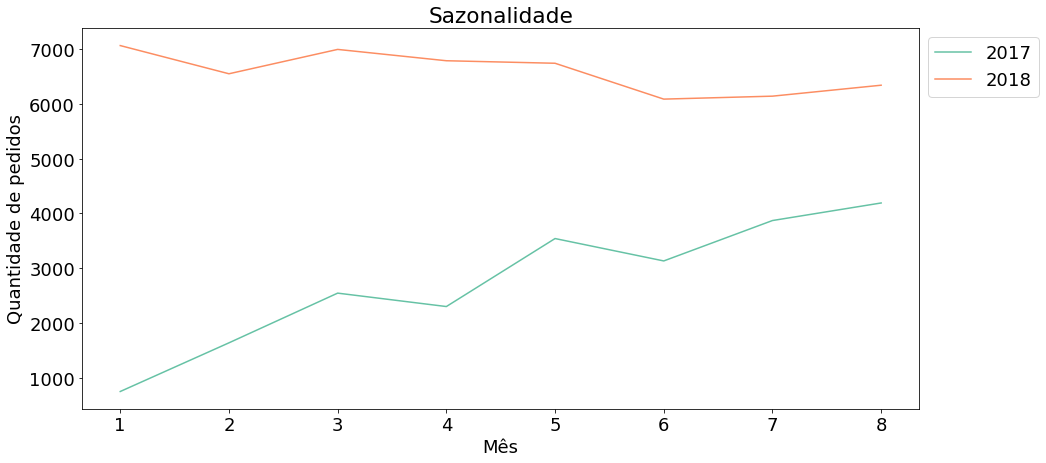

In [248]:
plt.figure(figsize=(15,7))
sazonalidade = data_aux.groupby(['mes_compra','ano_compra'])['id_pedido'].nunique().sort_values(ascending=True).reset_index()


sns.lineplot(data=sazonalidade, 
             x='mes_compra', 
             y='id_pedido', 
             hue='ano_compra', 
             legend='full',
             palette='Set2')
plt.title('Sazonalidade')
plt.ylabel('Quantidade de pedidos')
plt.xlabel('Mês')
# Movendo a legenda para fora do box
plt.legend(bbox_to_anchor=(1.0, 1), loc=2);

In [249]:
periodos_venda_ano=periodos_venda.groupby(['ano_compra'])['id_pedido'].sum().reset_index()
periodos_venda_ano

ano_compra  id_pedido
0        2017      21968
1        2018      52725

In [250]:
periodos_faturamento_ano=periodos_fat.groupby(['ano_compra'])['preço'].sum().reset_index()
periodos_faturamento_ano

ano_compra       preço
0        2017  3119077.79
1        2018  7401534.17

(0.0, 57997.50000000001)

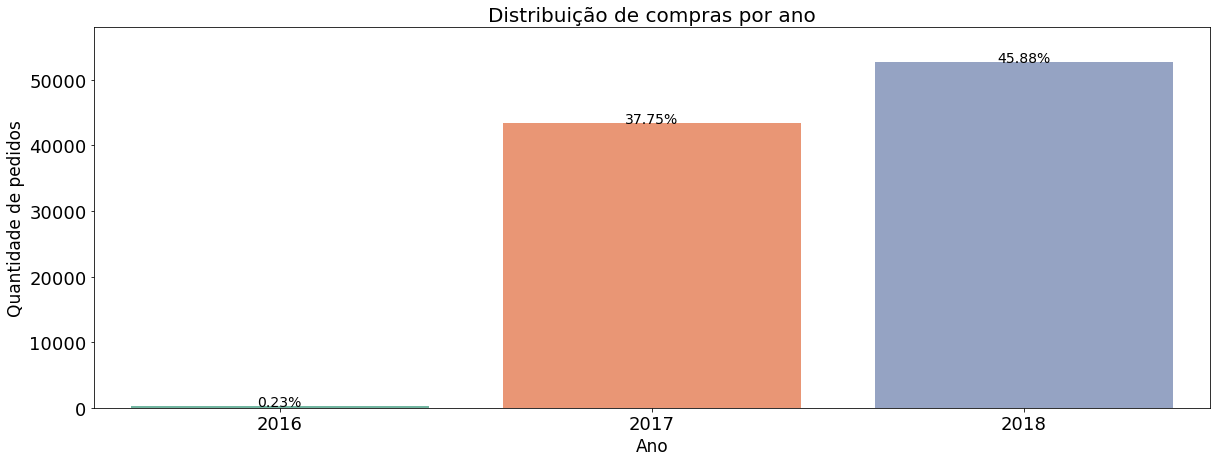

In [251]:
plt.figure(figsize=(20,7))
#sns.countplot(x='tipo_pagamento', data=data, palette='Set2')
plt.subplot(111)
sazonalidade_ano = data.groupby(['ano_compra'])['id_pedido'].nunique().sort_values(ascending=True).reset_index()
total=len(data)
g = sns.barplot(x='ano_compra', y='id_pedido', data=sazonalidade_ano, palette='Set2')
g.set_title("Distribuição de compras por ano", fontsize=20)
g.set_xlabel("Ano", fontsize=17)
g.set_ylabel("Quantidade de pedidos", fontsize=17)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.1)

(0.0, 8141687.587004743)

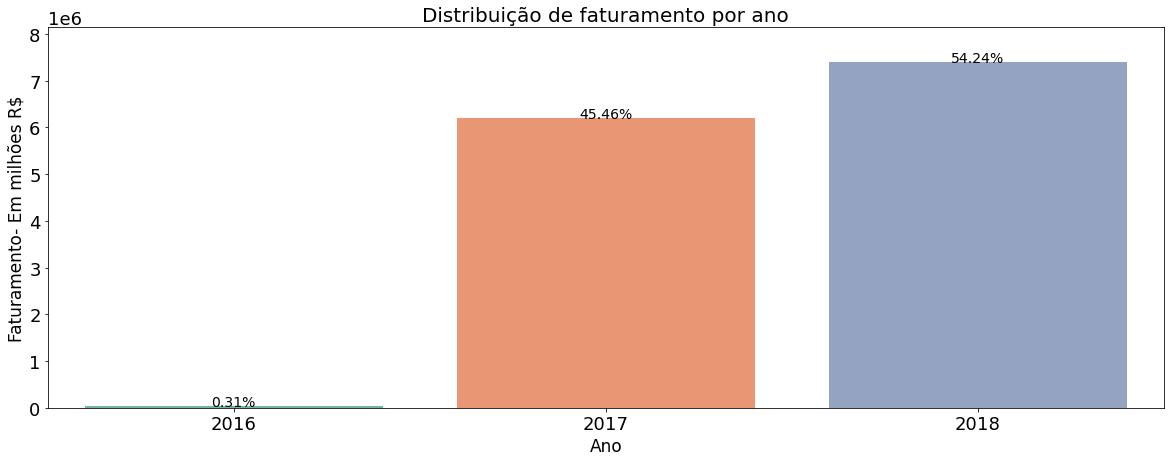

In [252]:
plt.figure(figsize=(20,7))
#sns.countplot(x='tipo_pagamento', data=data, palette='Set2')
plt.subplot(111)
sazonalidade_ano = data.groupby(['ano_compra'])['preço'].sum().sort_values(ascending=True).reset_index()
total=sum(sazonalidade_ano['preço'])
g = sns.barplot(x='ano_compra', y='preço', data=sazonalidade_ano, palette='Set2')
g.set_title("Distribuição de faturamento por ano", fontsize=20)
g.set_xlabel("Ano", fontsize=17)
g.set_ylabel("Faturamento- Em milhões R$", fontsize=17)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.1)

## Utilizando a amostra representativa - Período de 01-2017 a 08-2018

(0.0, 8141687.587000253)

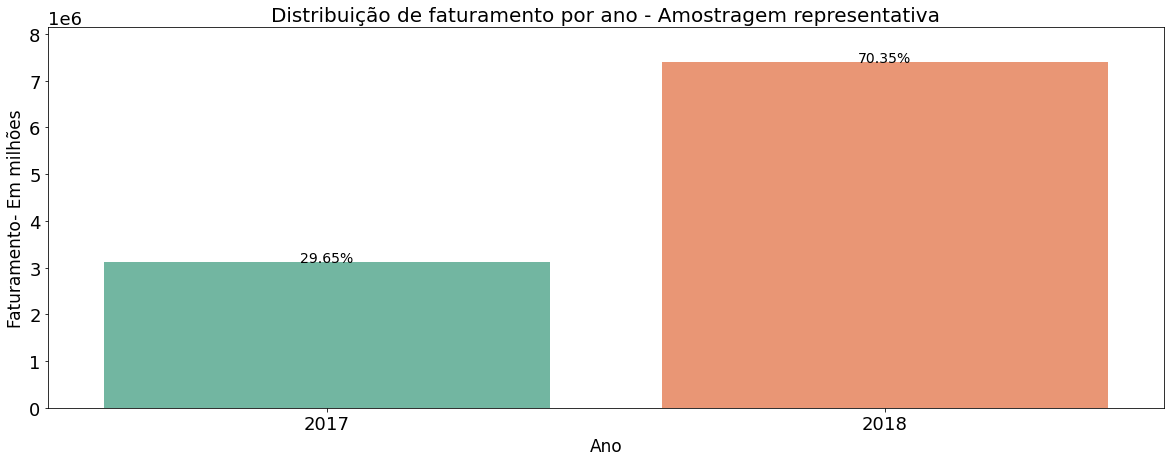

In [253]:
plt.figure(figsize=(20,7))
#sns.countplot(x='tipo_pagamento', data=data, palette='Set2')
plt.subplot(111)
sazonalidade_fat_ano = periodos_faturamento_ano
total= sum(periodos_faturamento_ano['preço'])
g = sns.barplot(x='ano_compra', y='preço', data=sazonalidade_fat_ano, palette='Set2')
g.set_title("Distribuição de faturamento por ano - Amostragem representativa", fontsize=20)
g.set_xlabel("Ano", fontsize=17)
g.set_ylabel("Faturamento- Em milhões", fontsize=17)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.1)

(0.0, 57997.50000000001)

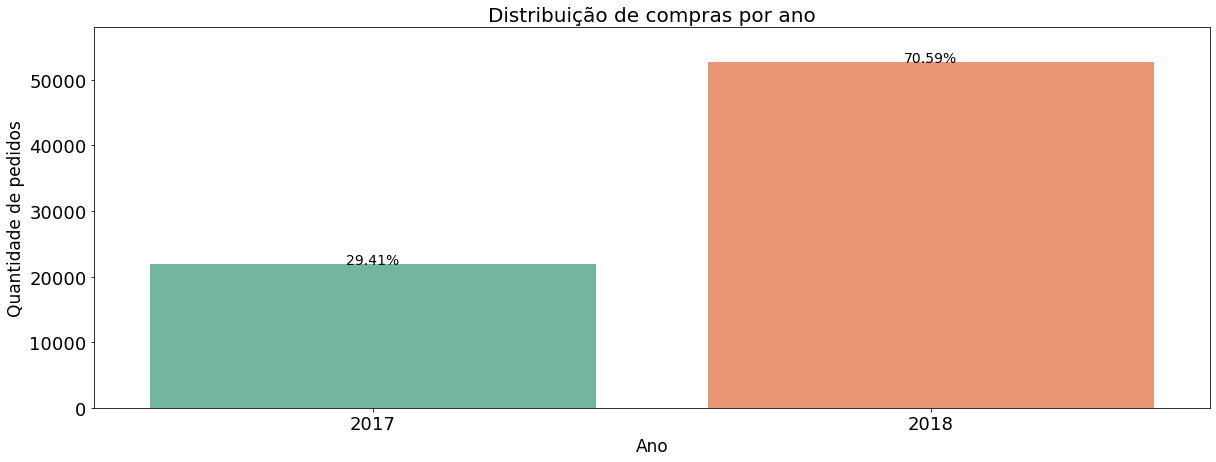

In [254]:
plt.figure(figsize=(20,7))
#sns.countplot(x='tipo_pagamento', data=data, palette='Set2')
plt.subplot(111)
sazonalidade_ano = periodos_venda_ano
total= sum(sazonalidade_ano['id_pedido'])
g = sns.barplot(x='ano_compra', y='id_pedido', data=sazonalidade_ano, palette='Set2')
g.set_title("Distribuição de compras por ano", fontsize=20)
g.set_xlabel("Ano", fontsize=17)
g.set_ylabel("Quantidade de pedidos", fontsize=17)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.1)

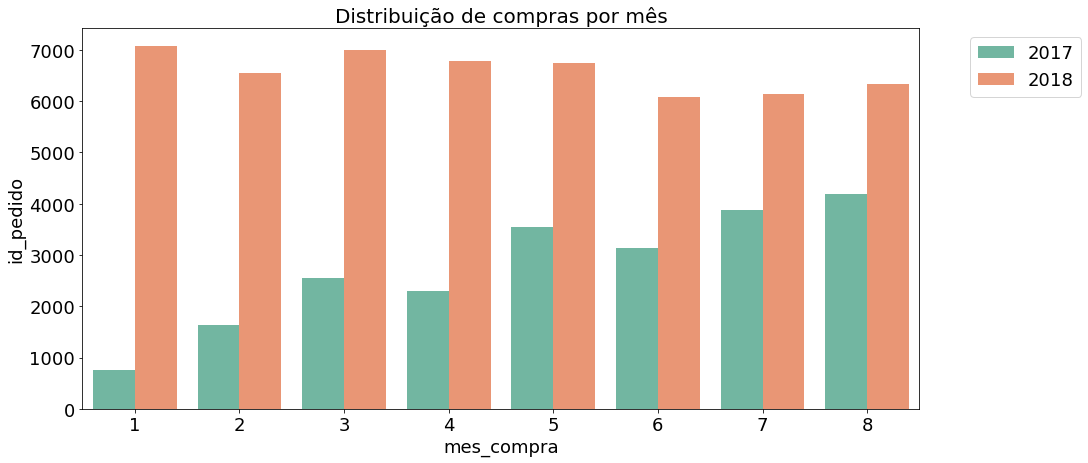

In [255]:
plt.figure(figsize=(15,7))
sns.barplot(x='mes_compra',y='id_pedido', hue='ano_compra', data=sazonalidade, palette='Set2')
plt.title("Distribuição de compras por mês", fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

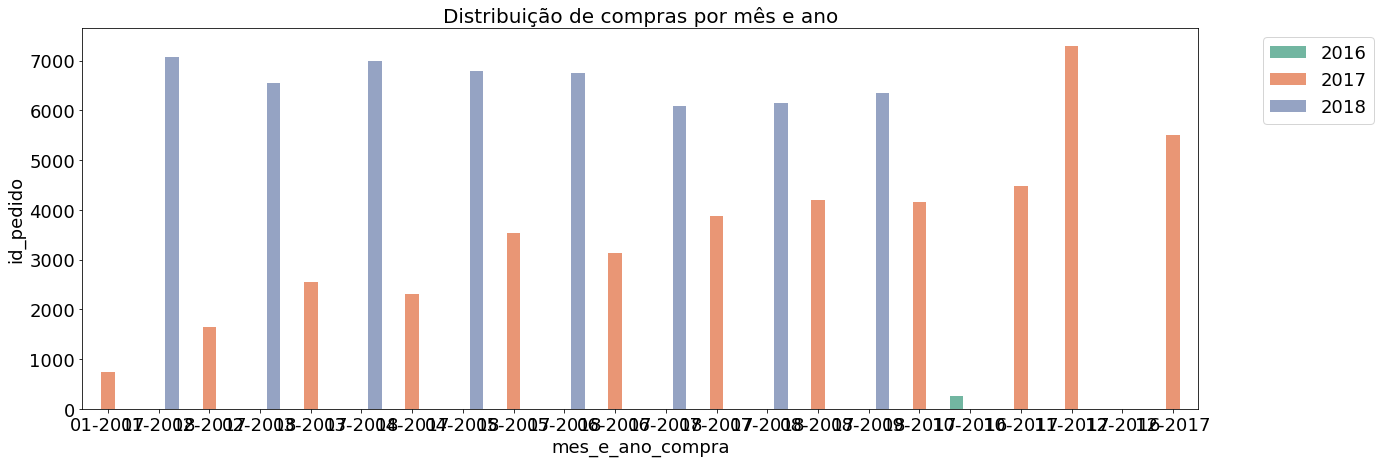

In [256]:
plt.figure(figsize=(20,7))
sazonalidade_periodo = data.groupby(['mes_e_ano_compra','ano_compra'])['id_pedido'].nunique().reset_index()
sns.barplot(x='mes_e_ano_compra',y='id_pedido',hue='ano_compra', data=sazonalidade_periodo, order = sazonalidade_periodo['mes_e_ano_compra'], palette='Set2')
plt.title("Distribuição de compras por mês e ano", fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

In [257]:
data['data_compra'].max()

datetime.date(2018, 8, 29)

O ponto de destaque ocorre no mês de novembro de 2017, cujo aumento de vendas pode estar relacionado à uma ação de marketing ou black friday por exemplo. Nota-se que a partir deste período, houve um aumento significativo de número de pedidos.

Ainda sobre o número de pedidos, se observada toda a amostra, houve um crescimento de 8% de 2018 em relação ao ano anterior. (Levando em consideração que o último registro da base é com a data de 29 de agosto de 2018)
Também considerando toda a amostra, como mostra o gráfico de faturamento por ano, o crescimento do faturamento seguiu o crescimento sobre o número de pedidos, obtendo 8% de ascenção em relação ao ano anterior.

Como existem dados faltantes, para que esta avaliação não seja influenciada pelo período do ano de 2018 cujo não existem dados a partir do mês de setembro, se utilizarmos a amostra representativa de dados definidos cujo período de ciclos completos é entre janeiro de 2017 e agosto de 2018, o número de pedidos sofre um aumento significativo de 41% entre um ano e outro, e é importante notar que neste período o crescimento do faturamento também seguiu o crescimento sobre o número de pedidos, obtendo 41% de ascenção em relação ao período anterior.

Não foi possível também identificar o percentual de crescimento do número de pedidos nem de faturamento de 2017 em relação a 2016 por falta de dados na base.

## Existe diferença de vendas por dia da semana? 

Text(0, 0.5, 'Quantidade de pedidos')

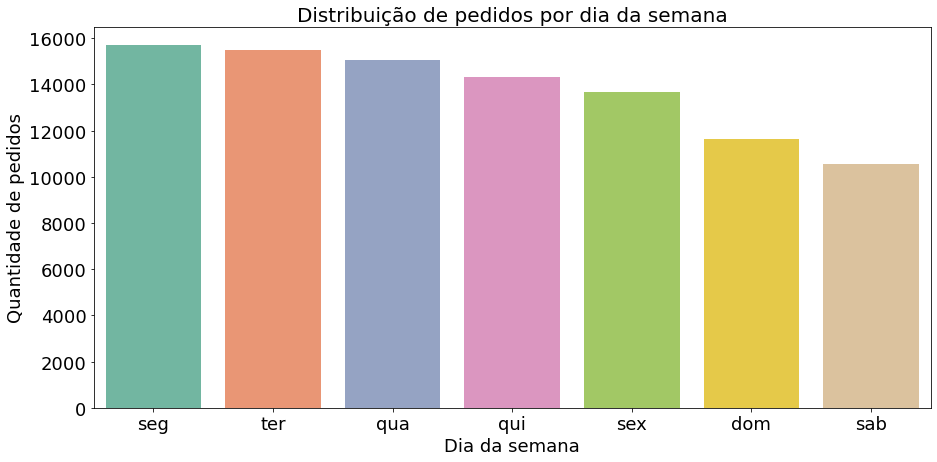

In [258]:
plt.figure(figsize=(15,7))
sazonalidade_semana = data.groupby(['dia_semana_compra'])['id_pedido'].nunique().sort_values(ascending=False).reset_index()
sns.barplot(x='dia_semana_compra',y='id_pedido', data=sazonalidade_semana, palette='Set2')
plt.title("Distribuição de pedidos por dia da semana", fontsize=20)
plt.xlabel('Dia da semana')
plt.ylabel('Quantidade de pedidos')


## Algum período do dia costuma ter mais vendas? 

Text(0.5, 0, 'Quantidade de pedidos')

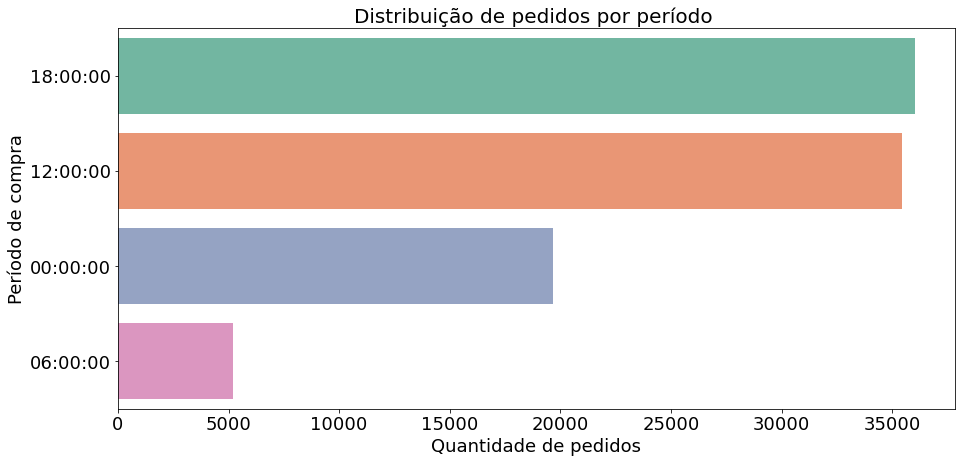

In [259]:
plt.figure(figsize=(15,7))
sazonalidade_hora = data.groupby(['hora_compra'])['id_pedido'].nunique().sort_values(ascending=False).reset_index()
sns.barplot(y='hora_compra', x='id_pedido',data=sazonalidade_hora, palette='Set2')
plt.title("Distribuição de pedidos por período ", fontsize=20)
plt.ylabel('Período de compra')
plt.xlabel('Quantidade de pedidos')

O fluxo de compras tende aumentar durante os dias de semana e no período da noite, entre seis da tarde e meia noite.

## Qual região do Brasil é a mais rentável?

<AxesSubplot:title={'center':'Total de pedidos por região'}, xlabel='regiao_cliente', ylabel='id_pedido'>

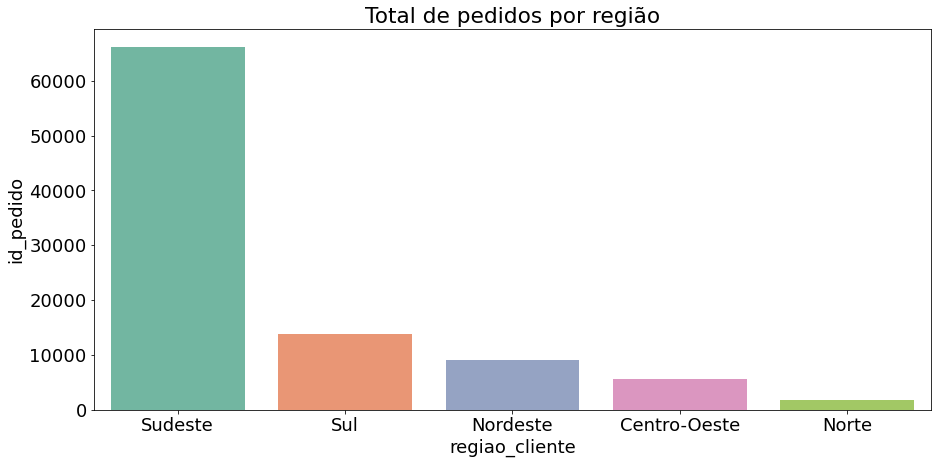

In [260]:
total_pedidos_regiao = data.groupby('regiao_cliente')['id_pedido'].nunique().sort_values(ascending=False)
plt.figure(figsize=(15,7))
total_pedidos_regiao
plt.title('Total de pedidos por região')
sns.barplot(x=total_pedidos_regiao.index, y=total_pedidos_regiao, palette='Set2')

In [261]:
#Correlação entre o PIB da região em relação as areas de venda

In [262]:
total_por_regiao = data.groupby(['regiao_cliente','preço'])['id_pedido'].nunique().sort_values(ascending=False).reset_index()
total_por_regiao = total_por_regiao.groupby('regiao_cliente')['preço'].sum().sort_values(ascending=False).reset_index()
total_por_regiao

regiao_cliente       preço
0        Sudeste  1191936.80
1            Sul   517289.97
2       Nordeste   467296.90
3   Centro-Oeste   304254.51
4          Norte   172364.28

<AxesSubplot:title={'center':'Valor Total região(Em milhões R$)'}, xlabel='regiao_cliente', ylabel='preço'>

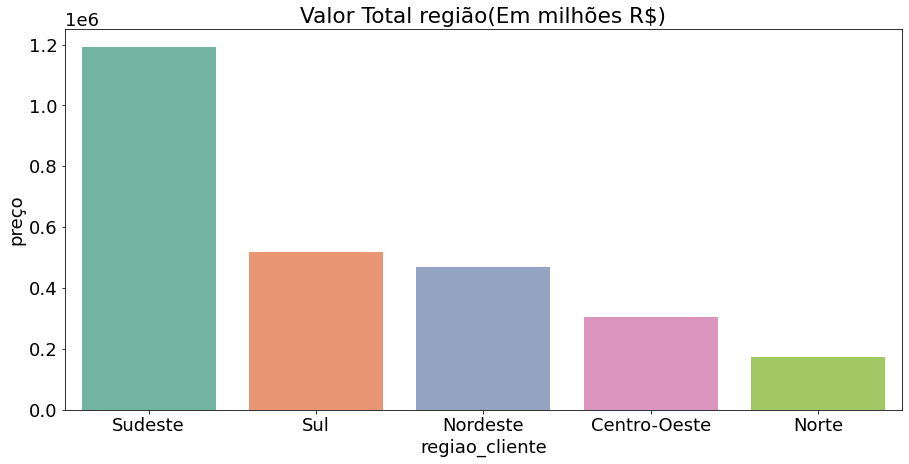

In [263]:
plt.figure(figsize=(15,7))
plt.title('Valor Total região(Em milhões R$)')
sns.barplot(x='regiao_cliente', y='preço', data=total_por_regiao, palette='Set2')

## Qual Estado do Brasil é o mais rentável? 

<AxesSubplot:title={'center':'Total de pedidos por estado'}, xlabel='estado_cliente', ylabel='id_pedido'>

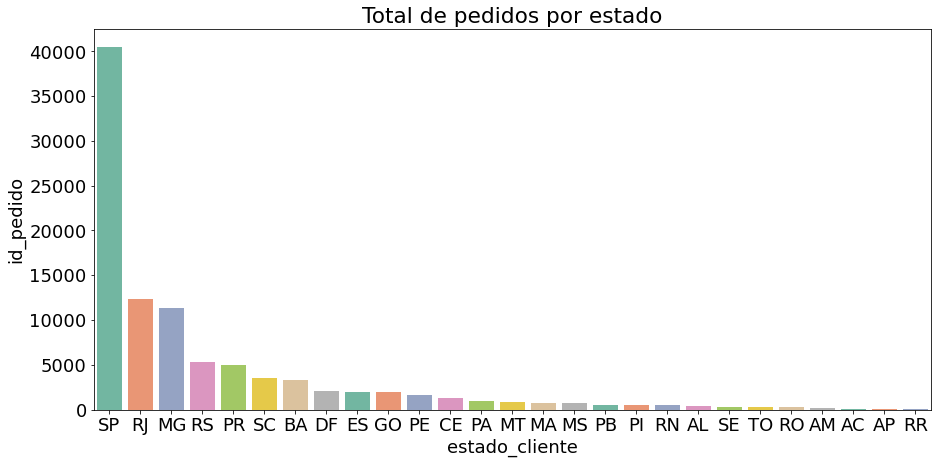

In [264]:
total_pedidos_estado = data.groupby('estado_cliente')['id_pedido'].nunique().sort_values(ascending=False)
plt.figure(figsize=(15,7))
plt.title('Total de pedidos por estado')
sns.barplot(x=total_pedidos_estado.index, y=total_pedidos_estado, palette='Set2')

In [265]:
total_por_estado = data.groupby(['estado_cliente','preço'])['id_pedido'].nunique().sort_values(ascending=False).reset_index()
total_por_estado = total_por_estado.groupby('estado_cliente')['preço'].sum().sort_values(ascending=False).reset_index()
total_por_estado.head(10)

estado_cliente      preço
0             SP  893259.67
1             RJ  476991.54
2             MG  425062.49
3             RS  265944.89
4             PR  258655.74
5             SC  218255.37
6             BA  215168.06
7             DF  138954.77
8             GO  138583.39
9             PE  127574.35

<AxesSubplot:title={'center':'Valor Total por estado (R$)'}, xlabel='estado_cliente', ylabel='preço'>

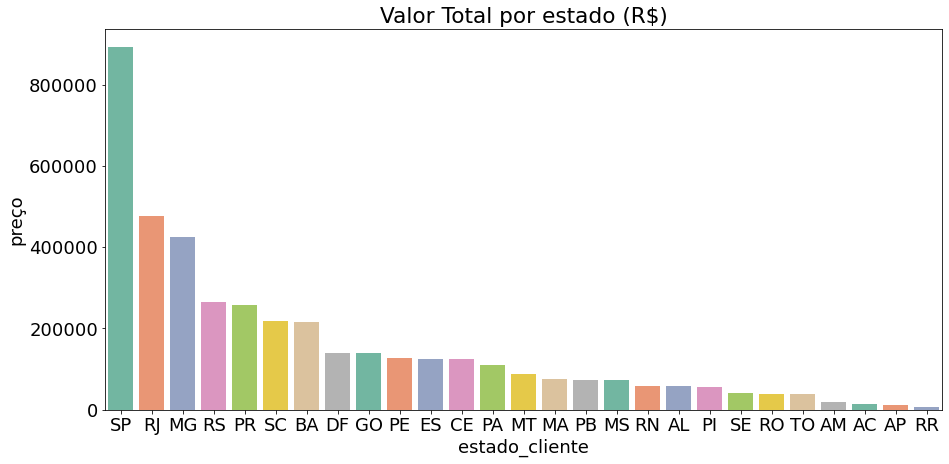

In [266]:
plt.figure(figsize=(15,7))
plt.title('Valor Total por estado (R$)')
sns.barplot(x='estado_cliente', y='preço',data=total_por_estado, palette='Set2')

## Qual a Cidade mais rentável? 

In [267]:
total_por_cidade = data.groupby(['cidade_cliente','preço'])['id_pedido'].nunique().sort_values(ascending=False).reset_index()
total_por_cidade = total_por_cidade.groupby('cidade_cliente')['preço'].sum().sort_values(ascending=False).reset_index().head(10)
total_por_cidade

cidade_cliente      preço
0       sao paulo  484113.28
1  rio de janeiro  328910.87
2  belo horizonte  153253.06
3        brasilia  138944.78
4        curitiba  113784.55
5        campinas  102884.40
6        salvador   95684.62
7    porto alegre   87044.27
8       guarulhos   74236.10
9         niteroi   66727.17

<AxesSubplot:title={'center':'Top 10 cidades mais rentáveis (R$)'}, xlabel='cidade_cliente', ylabel='preço'>

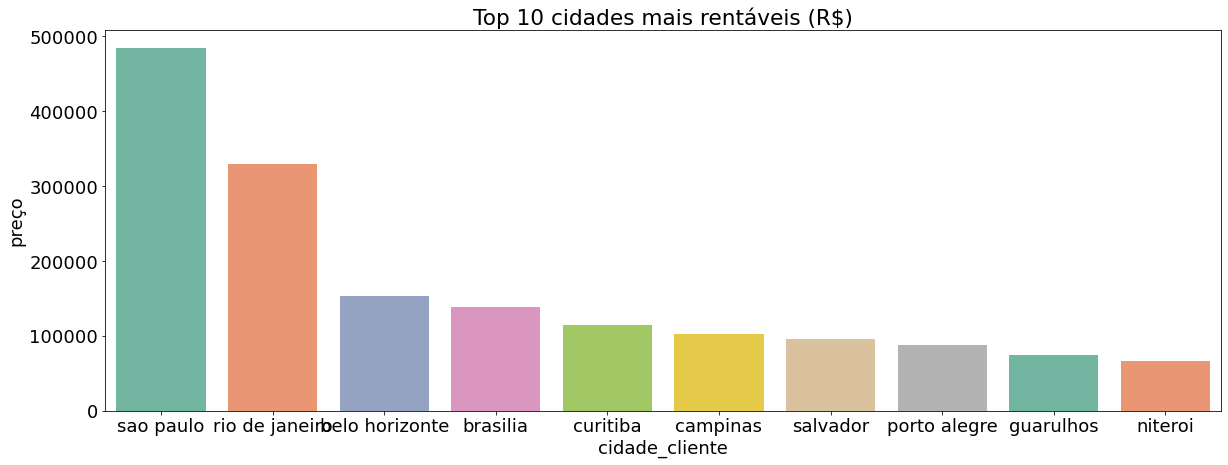

In [268]:
plt.figure(figsize=(20,7))
plt.title('Top 10 cidades mais rentáveis (R$)')
sns.barplot(x='cidade_cliente', y='preço',data=total_por_cidade, palette='Set2')

A região que realiza mais pedidos e também gasta mais é a Região Sudeste, em destaque estão os estados de São Paulo, Rio de Janeiro e Minas Gerais. Entre as cidades, capitais dos estados ganham destaque.

## Quais os produtos mais rentaveis?

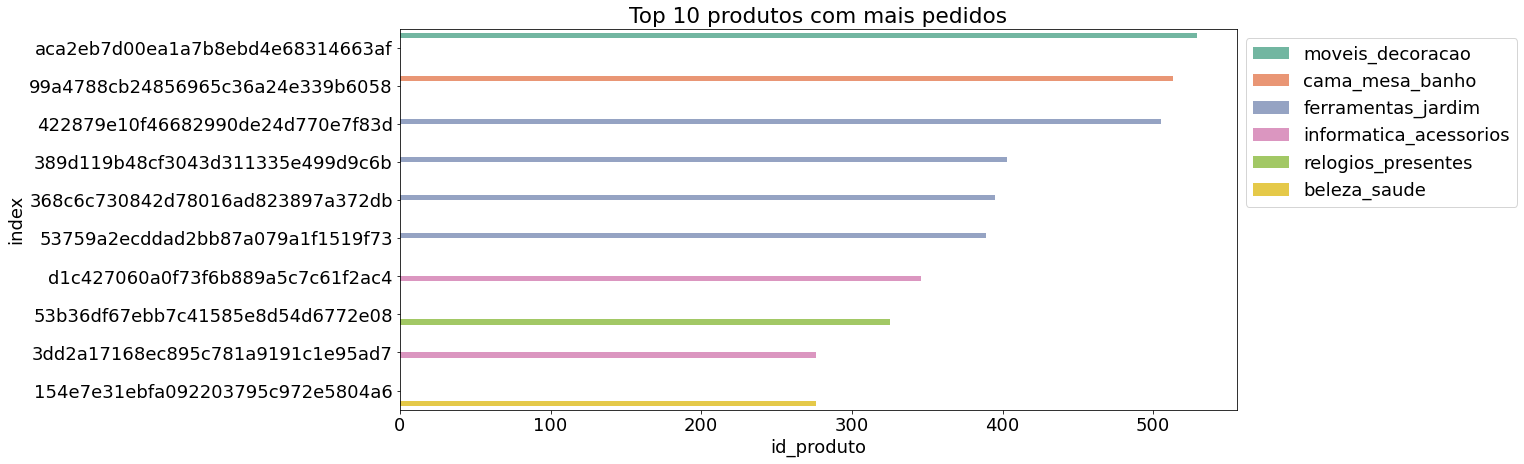

In [269]:
produtos_mais_procurados = data['id_produto'].value_counts().reset_index().head(10)
data__products.rename(columns={'product_id': 'index'}, inplace = True)
produtos_mais_procurados = pd.merge(produtos_mais_procurados,data__products, on='index', how='inner')
#data__products.head(10)
#produtos_mais_procurados.head(10)
plt.figure(figsize=(15,7))
plt.title('Top 10 produtos com mais pedidos')
sns.barplot( x=produtos_mais_procurados['id_produto'],y=produtos_mais_procurados['index'], hue=produtos_mais_procurados['product_category_name'], palette="Set2")

plt.legend(bbox_to_anchor=(1, 1), loc=2);

O gráfico acima determina a categoria com o maior número de pedidos. Porém, o objetivo principal desta análise é determinar qual é o produto por categoria que alcança o número de vendas aceitável à meta, mas por falta de informações, não é possível identificá-lo.
O produto que recebeu o maior número de pedidos pertence à categoria de móveis e decoração, com mais de 500 itens vendidos. 


## Quais as categorias menos rentáveis?

In [270]:
produtos_menos_vendidos = data.groupby('categoria')['id_pedido'].nunique().sort_values(ascending=True).head(5)

produtos_menos_vendidos

categoria
seguros_e_servicos                                2
pc_gamer                                          7
fashion_roupa_infanto_juvenil                     7
cds_dvds_musicais                                12
portateis_cozinha_e_preparadores_de_alimentos    13
Name: id_pedido, dtype: int64

## Quais as categorias mais rentáveis por região?

In [271]:
total_regiao = data.groupby(['regiao_cliente','preço','categoria','id_produto'])['id_pedido'].nunique().sort_values(ascending=False).reset_index()
produtos_rentaveis_regiao=total_regiao.groupby(['regiao_cliente','categoria']).agg({'preço': np.sum, 'id_produto': np.size},'qtd').reset_index()
produtos_rentaveis_regiao.sample(10)
produtos_rentaveis_regiao.rename(columns={'id_produto': 'qtd_produto'}, inplace = True)

produtos_rentaveis_sudeste= produtos_rentaveis_regiao.loc[produtos_rentaveis_regiao['regiao_cliente']=='Sudeste']
produtos_rentaveis_sudeste=produtos_rentaveis_sudeste.sort_values('preço', ascending=False).head(5)


produtos_rentaveis_centroOeste= produtos_rentaveis_regiao.loc[produtos_rentaveis_regiao['regiao_cliente']=='Centro-Oeste']
produtos_rentaveis_centroOeste=produtos_rentaveis_centroOeste.sort_values('preço', ascending=False).head(5)


produtos_rentaveis_sul= produtos_rentaveis_regiao.loc[produtos_rentaveis_regiao['regiao_cliente']=='Sul']
produtos_rentaveis_sul=produtos_rentaveis_sul.sort_values('preço', ascending=False).head(5)


produtos_rentaveis_norte= produtos_rentaveis_regiao.loc[produtos_rentaveis_regiao['regiao_cliente']=='Norte']
produtos_rentaveis_norte=produtos_rentaveis_norte.sort_values('preço', ascending=False).head(5)


produtos_rentaveis_nordeste= produtos_rentaveis_regiao.loc[produtos_rentaveis_regiao['regiao_cliente']=='Nordeste']
produtos_rentaveis_nordeste=produtos_rentaveis_nordeste.sort_values('preço', ascending=False).head(5)
#plt.figure(figsize=(15,7))
#plt.title('Top 5 ')
#sns.barplot(y="preço",x="categoria",hue="regiao_cliente", palette="Set2", data=produtos_rentaveis_nordeste)



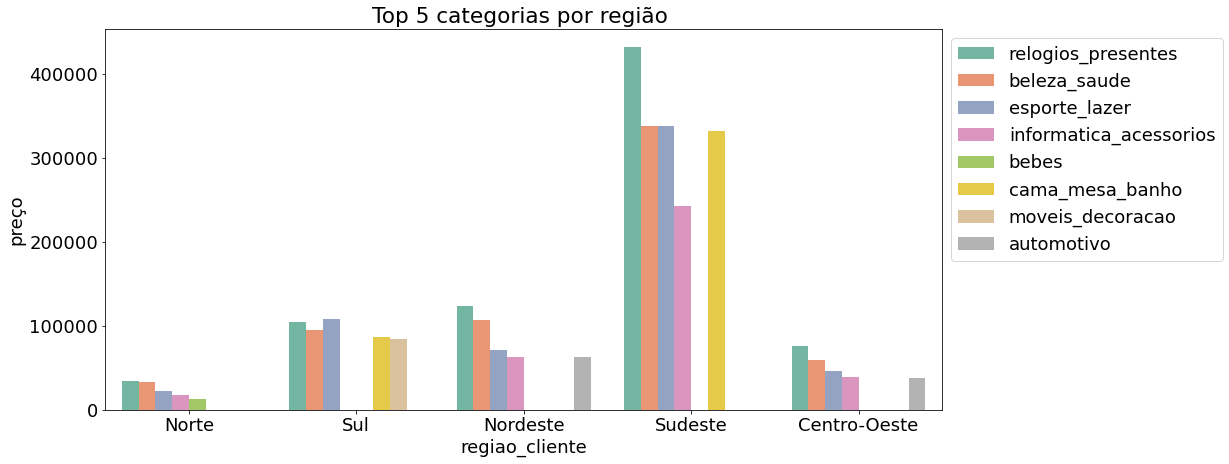

In [272]:
produtos_rentaveis_regiao= pd.concat([produtos_rentaveis_norte, produtos_rentaveis_sul,produtos_rentaveis_nordeste,produtos_rentaveis_sudeste,produtos_rentaveis_centroOeste])
plt.figure(figsize=(15,7))
plt.title('Top 5 categorias por região ')
sns.barplot(y="preço",x="regiao_cliente",hue="categoria",palette="Set2", data=produtos_rentaveis_regiao)
plt.legend(bbox_to_anchor=(1, 1), loc=2);

O comportamento de compra se altera por região, mas foi possível notar que as categorias de relogios_presentes beleza e saúde e esporte e lazer estão entre as preferidas de todas as regiões.


## Qual o valor médio dos produtos? 

In [273]:
data.agg({'preço':np.mean})
#colocar cifrão

preço    118.750703
dtype: float64

## Qual o valor médio dos fretes? 

In [274]:
data.agg({'valor_frete': np.mean})

valor_frete    19.837798
dtype: float64

## Os clientes geralmente ficam satisfeitos com as compras?

In [275]:
data__order_reviews.head()

order_id  review_score
0  73fc7af87114b39712e6da79b0a377eb             4
1  a548910a1c6147796b98fdf73dbeba33             5
2  f9e4b658b201a9f2ecdecbb34bed034b             5
3  658677c97b385a9be170737859d3511b             5
4  8e6bfb81e283fa7e4f11123a3fb894f1             5

<AxesSubplot:ylabel='Density'>

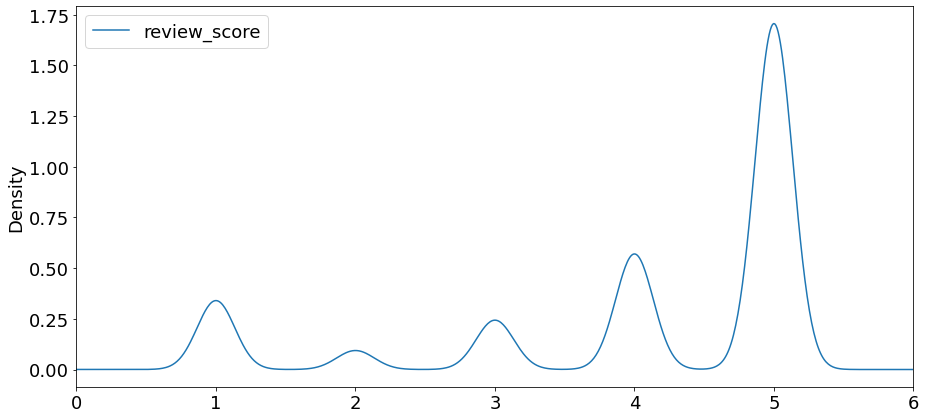

In [276]:
data__order_reviews.plot.density(y='review_score',xlim=[0,6],figsize=[15,7])

A maioria dos clientes deram notas positivas e ficaram satisfeitos com suas compras na Olist.

## Existe recorrência de compra? 

In [277]:
data.columns

Index(['id_pedido', 'status_pedido', 'dia_compra', 'mes_compra', 'ano_compra',
       'dia_semana_compra', 'mes_e_ano_compra', 'data_compra', 'hora_compra',
       'tipo_pagamento', 'ordem_pagamento', 'qtd_parcelas', 'total_pago',
       'dif_previsao_entrega', 'id_produto', 'categoria', 'id_item_pedido',
       'preço', 'valor_frete', 'nota', 'id_cliente', 'customer_unique_id',
       'cidade_cliente', 'estado_cliente', 'regiao_cliente'],
      dtype='object')

In [278]:
max_date = max(data['data_compra']) + datetime.timedelta(days=1)

In [279]:
recorrencia = data.groupby(['customer_unique_id','data_compra','id_cliente','preço'])['id_pedido'].nunique().sort_values(ascending=False).reset_index()
recorrencia = recorrencia.groupby(['customer_unique_id']).agg({
    'data_compra': lambda x: (max_date - x.max()).days,
    'id_cliente':'count',
    'preço':'sum'
}).reset_index()
#Compra recente faz um comparativo com a ultima data que temos na base, e verifica quanto tempo a compra foi feita
#a partir desta data. Exemplo, compra recente - 112, esta compra foi feita 112 dias antes da última data que 
#temos na base
recorrencia.columns =['id_cliente','recencia','frequencia','valor_gasto']
recorrencia.head()
#Frequencia é o numero de vezes que um mesmo cliente fez compras na loja, independente da quantidade de itens. 
#Sendo o máximo, 42
#75 é o numero maximo de itens do carrinho na base

id_cliente  recencia  frequencia  valor_gasto
0  0000366f3b9a7992bf8c76cfdf3221e2       112           1       129.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f       115           1        18.90
2  0000f46a3911fa3c0805444483337064       538           1        69.00
3  0000f6ccb0745a6a4b88665a16c9f078       322           1        25.99
4  0004aac84e0df4da2b147fca70cf8255       289           1       180.00

In [280]:
#Verificação de valores faltantes
print(recorrencia.shape[0],recorrencia[recorrencia['frequencia']>1].shape[0])
recorrencia.isnull().sum().sort_values(ascending=False)

93260 4896


id_cliente     0
recencia       0
frequencia     0
valor_gasto    0
dtype: int64

A porcentagem de recorrência é  5.249839159339481
count    93260.000000
mean         1.061055
std          0.288132
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
Name: frequencia, dtype: float64


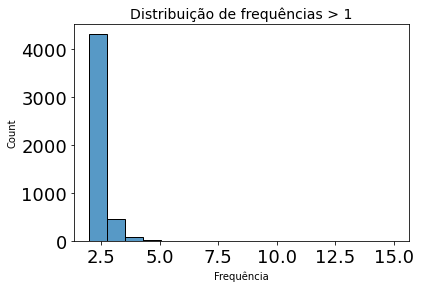

In [281]:
print('A porcentagem de recorrência é ',recorrencia[recorrencia['frequencia']>1].shape[0] / recorrencia.shape[0]*100)
print(recorrencia['frequencia'].describe())
sns.histplot(x='frequencia', data=recorrencia[recorrencia['frequencia']>1],bins=17)
plt.title('Distribuição de frequências > 1',fontsize=14)
plt.ylabel('Count',fontsize=10)
plt.xlabel('Frequência',fontsize=10)
data['recencia']=recorrencia['recencia']
data['frequencia']=recorrencia['valor_gasto']

Como pudemos ver, cerca de 5% dos compradores fizeram mais de uma compra no e-commerce, com clientes que fizeram até 15 compras no período analisado.

## Os clientes que fazem mais compras são os que gastam mais? 

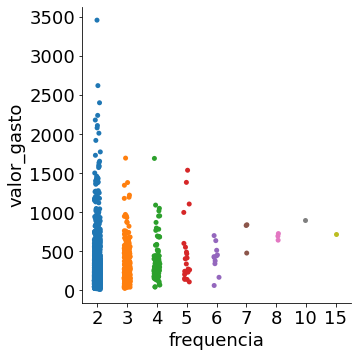

In [282]:
clientes_freq =recorrencia.loc[recorrencia['frequencia']>1].sort_values('valor_gasto', ascending=False)
clientes_sem_freq = recorrencia.loc[recorrencia['frequencia']==1].sort_values('valor_gasto', ascending=False).head(5)                                  

sns.catplot(y="valor_gasto",x="frequencia", data=clientes_freq)

##  Qual o prazo médio de dias entre compra e entrega?

count    114920.000000
mean         11.040263
std          10.161005
min        -189.000000
25%           6.000000
50%          12.000000
75%          16.000000
max         146.000000
Name: dif_previsao_entrega, dtype: float64


Text(0.5, 1.0, 'Distribuição de diferença de dias de entrega')

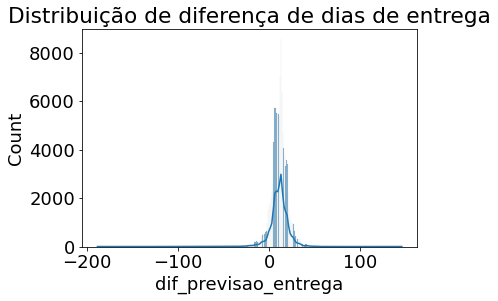

In [283]:
print(data['dif_previsao_entrega'].describe())
sns.histplot(x='dif_previsao_entrega', data=data, kde=True, palette='Set2')
plt.title('Distribuição de diferença de dias de entrega')
#Fazer scatter


Os produtos levam em média 12 dias a menos do que a data prevista para a entrega

## O preço influencia no número das parcelas?

In [284]:
data.head(2)

id_pedido status_pedido  dia_compra  mes_compra  \
0  e481f51cbdc54678b7cc49136f2d6af7     delivered           2          10   
1  e481f51cbdc54678b7cc49136f2d6af7     delivered           2          10   

   ano_compra dia_semana_compra mes_e_ano_compra data_compra hora_compra  \
0        2017               seg          10-2017  2017-10-02    12:00:00   
1        2017               seg          10-2017  2017-10-02    12:00:00   

  tipo_pagamento  ...  preço  valor_frete  nota  \
0    credit_card  ...  29.99         8.72   4.0   
1        voucher  ...  29.99         8.72   4.0   

                         id_cliente                customer_unique_id  \
0  9ef432eb6251297304e76186b10a928d  7c396fd4830fd04220f754e42b4e5bff   
1  9ef432eb6251297304e76186b10a928d  7c396fd4830fd04220f754e42b4e5bff   

  cidade_cliente  estado_cliente  regiao_cliente  recencia  frequencia  
0      sao paulo              SP         Sudeste     112.0       129.9  
1      sao paulo              SP         Sudeste     115.0        18.9  

[2 rows x 27 columns]

In [285]:
total_influencia_parcelas = data.groupby(['id_cliente','tipo_pagamento','mes_compra','qtd_parcelas','preço'])['id_pedido'].nunique().sort_values(ascending=False).reset_index()
total_influencia_parcelas=total_influencia_parcelas.groupby(['id_cliente','tipo_pagamento','mes_compra']).agg({'preço':'sum','qtd_parcelas':'sum'}).reset_index()
total_influencia_parcelas.head()

id_cliente tipo_pagamento  mes_compra   preço  \
0  00012a2ce6f8dcda20d059ce98491703    credit_card          11   89.80   
1  000161a058600d5901f007fab4c27140    credit_card           7   54.90   
2  0001fd6190edaaf884bcaf3d49edf079    credit_card           2  179.99   
3  0002414f95344307404f0ace7a26f1d5         boleto           8  149.90   
4  000379cdec625522490c315e70c7a9fb         boleto           4   93.00   

   qtd_parcelas  
0           8.0  
1           5.0  
2          10.0  
3           1.0  
4           1.0

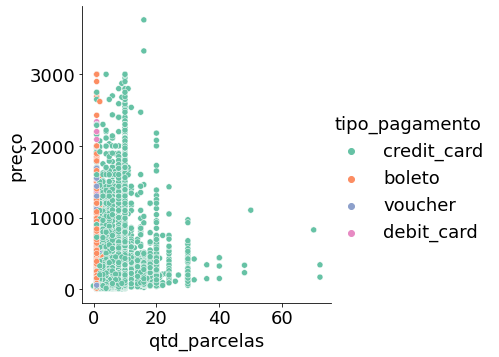

In [286]:
sns.relplot(y="preço",x="qtd_parcelas",hue="tipo_pagamento",sizes=(15,300), data=total_influencia_parcelas,palette='Set2')

## O Tipo de pagamento influencia na sazonalidade (Se existente) das vendas?

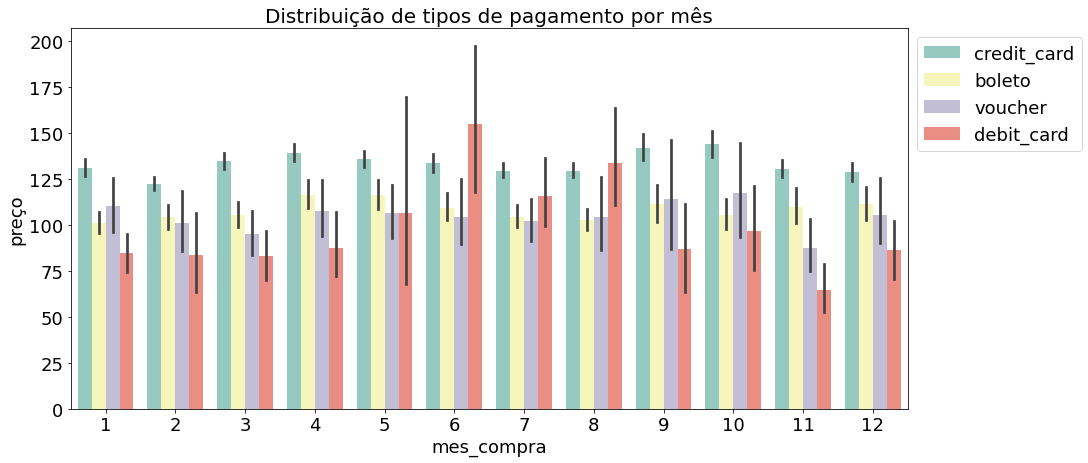

In [287]:
plt.figure(figsize=(15,7))

sns.barplot(x='mes_compra',y='preço', hue='tipo_pagamento', data=total_influencia_parcelas, palette='Set3')
#Gráfico enviesado, pois a base de 2018 vai somente até agosto de 2018.
g.set_xlabel("Ano", fontsize=14)
g.set_ylabel("Quantidade de pedidos", fontsize=14)
plt.title("Distribuição de tipos de pagamento por mês", fontsize=20)
plt.legend(bbox_to_anchor=(1.0, 1), loc=2);

Como mostra o gráfico, a maioria das pessoas utiliza o cartão de crédito como meio de pagamento. Existe uma tendência de aumento de pagamentos feitos por cartão de crédito no primeiro trimestre do ano.

In [288]:
data['id_item_pedido']

0         1
1         1
2         1
3         1
4         1
         ..
115009    1
115010    1
115011    1
115012    2
115013    1
Name: id_item_pedido, Length: 114920, dtype: int64

## Os clientes costumam fazer compras com mais de um item no pedido?

In [289]:
data['qtd_itens'] = data['id_item_pedido'].copy()
data.loc[data['id_item_pedido'].isin([2,3,4,5,6]), 'qtd_itens'] = 'de 2 a 6' #analisar como pegar o item 1 pra agrupar aqui qndo tem mais itens
data.loc[data['id_item_pedido'].isin([7,8,9,10]), 'qtd_itens'] = 'de 7 a 10'
data.loc[(data['id_item_pedido'] > 10), 'qtd_itens'] = 'de 10 a 20'

(0.0, 110717.20000000001)

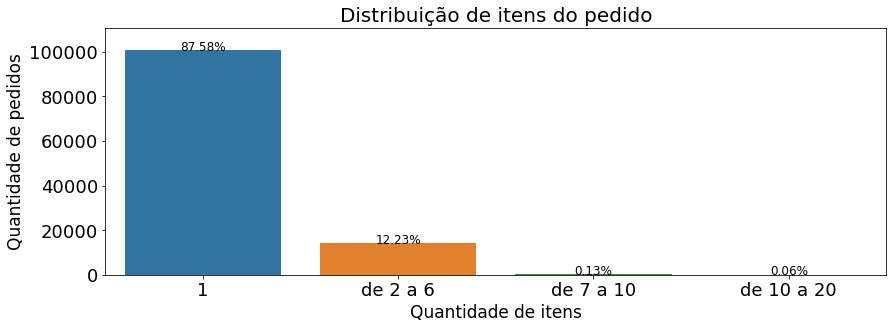

In [290]:
plt.figure(figsize=(14,10))
total=len(data)
plt.subplot(211)
g = sns.countplot(x='qtd_itens', data=data)
g.set_title("Distribuição de itens do pedido", fontsize=20)
g.set_xlabel("Quantidade de itens", fontsize=17)
g.set_ylabel("Quantidade de pedidos", fontsize=17)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12) 
g.set_ylim(0, max(sizes) * 1.1)

Mais de 80% dos pedidos com status de 'Entregue' possuiam apenas um item no carrinho.

## O Valor do frete sofre influência pelo Estado/Região? 

In [291]:

fig = px.line_polar(data, r=data['valor_frete'], theta='regiao_cliente', 
                    title='Polar seasonal plot',
                    width=600, height=600)
fig.update_polars(angularaxis_type="category") 
fig.show()

As regiões que tiveram os valores de frete mais caros foram o nordeste e o sul.

In [292]:
data.head()

id_pedido status_pedido  dia_compra  mes_compra  \
0  e481f51cbdc54678b7cc49136f2d6af7     delivered           2          10   
1  e481f51cbdc54678b7cc49136f2d6af7     delivered           2          10   
2  e481f51cbdc54678b7cc49136f2d6af7     delivered           2          10   
3  53cdb2fc8bc7dce0b6741e2150273451     delivered          24           7   
4  47770eb9100c2d0c44946d9cf07ec65d     delivered           8           8   

   ano_compra dia_semana_compra mes_e_ano_compra data_compra hora_compra  \
0        2017               seg          10-2017  2017-10-02    12:00:00   
1        2017               seg          10-2017  2017-10-02    12:00:00   
2        2017               seg          10-2017  2017-10-02    12:00:00   
3        2018               ter          07-2018  2018-07-24    18:00:00   
4        2018               qua          08-2018  2018-08-08    06:00:00   

  tipo_pagamento  ...  valor_frete  nota                        id_cliente  \
0    credit_card  ...         8.72   4.0  9ef432eb6251297304e76186b10a928d   
1        voucher  ...         8.72   4.0  9ef432eb6251297304e76186b10a928d   
2        voucher  ...         8.72   4.0  9ef432eb6251297304e76186b10a928d   
3         boleto  ...        22.76   4.0  b0830fb4747a6c6d20dea0b8c802d7ef   
4    credit_card  ...        19.22   5.0  41ce2a54c0b03bf3443c3d931a367089   

                 customer_unique_id cidade_cliente estado_cliente  \
0  7c396fd4830fd04220f754e42b4e5bff      sao paulo             SP   
1  7c396fd4830fd04220f754e42b4e5bff      sao paulo             SP   
2  7c396fd4830fd04220f754e42b4e5bff      sao paulo             SP   
3  af07308b275d755c9edb36a90c618231      barreiras             BA   
4  3a653a41f6f9fc3d2a113cf8398680e8     vianopolis             GO   

   regiao_cliente  recencia  frequencia  qtd_itens  
0         Sudeste     112.0      129.90          1  
1         Sudeste     115.0       18.90          1  
2         Sudeste     538.0       69.00          1  
3        Nordeste     322.0       25.99          1  
4    Centro-Oeste     289.0      180.00          1  

[5 rows x 28 columns]

In [293]:
df_data=data

In [294]:
df_data = data.groupby(['id_cliente']).agg({
    'qtd_parcelas':'mean',
    'dif_previsao_entrega':'mean',
    'nota':'mean',
    'valor_frete':'sum',
    'recencia':'mean',
    'frequencia':'mean',
    'preço':'sum'
}).reset_index()
df_data.head()

id_cliente  qtd_parcelas  dif_previsao_entrega  nota  \
0  00012a2ce6f8dcda20d059ce98491703           8.0                     5   1.0   
1  000161a058600d5901f007fab4c27140           5.0                     9   4.0   
2  0001fd6190edaaf884bcaf3d49edf079          10.0                    15   5.0   
3  0002414f95344307404f0ace7a26f1d5           1.0                     0   5.0   
4  000379cdec625522490c315e70c7a9fb           1.0                     4   4.0   

   valor_frete  recencia  frequencia   preço  
0        24.94     252.0      243.89   89.80  
1        12.51      64.0      139.90   54.90  
2        15.43     268.0       22.80  179.99  
3        29.45     234.0       89.99  149.90  
4        14.01     183.0      207.91   93.00

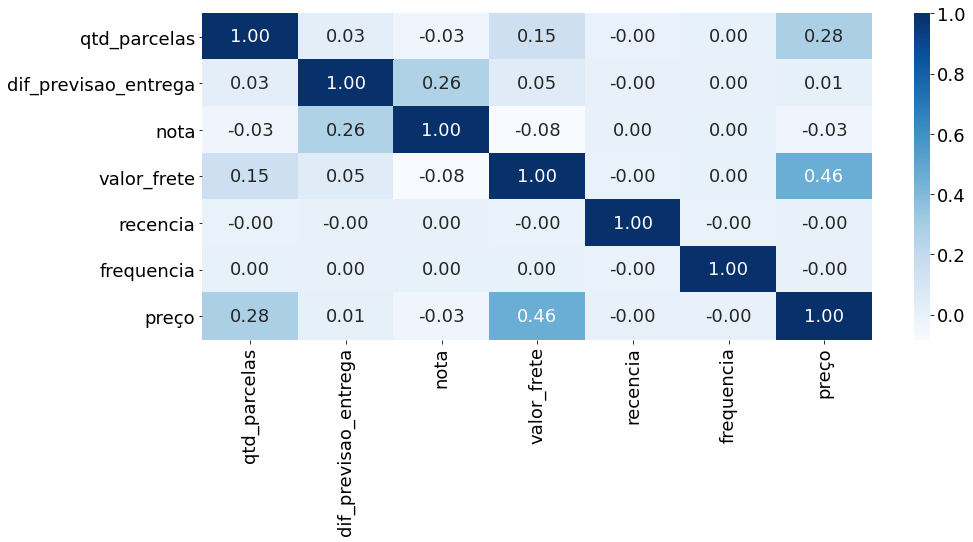

In [295]:
plt.figure(figsize=(15, 6))
sns.heatmap(df_data.corr(),
            annot = True,
            fmt = '.2f',
            cmap='Blues')
plt.show()

In [296]:
vendas_mesano= data_aux.groupby(['mes_compra','ano_compra']).agg({
    'preço':'sum',
    'id_cliente':'count'}).reset_index()
vendas_mesano

mes_compra  ano_compra       preço  id_cliente
0            1        2017   120037.59         961
1            1        2018   955643.87        8361
2            2        2017   226378.31        1945
3            2        2018   856125.42        7760
4            3        2017   377305.69        3077
5            3        2018   984885.53        8331
6            4        2017   343670.69        2703
7            4        2018   992908.75        8104
8            5        2017   519499.78        4256
9            5        2018  1004439.76        8098
10           6        2017   439356.18        3684
11           6        2018   882742.91        7309
12           7        2017   514588.46        4725
13           7        2018   870335.05        7178
14           8        2017   578241.09        5052
15           8        2018   854452.88        7346

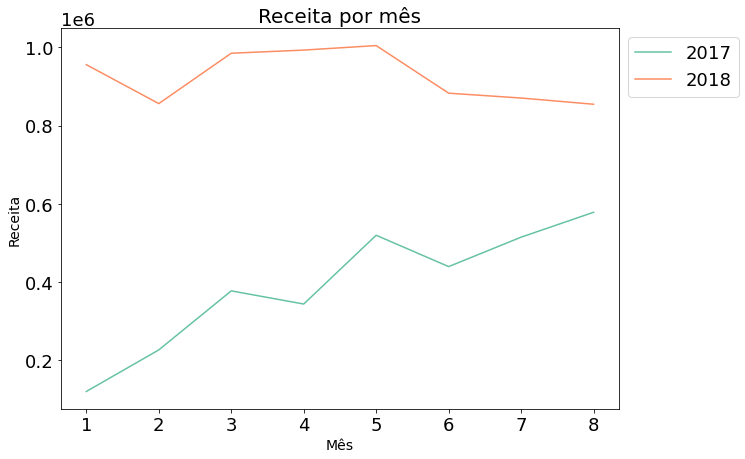

In [297]:
#receita por mes X quantidade de compras
plt.figure(figsize=(10,7))
sns.lineplot(x="mes_compra", y="preço", hue='ano_compra',palette="Set2",
             data=vendas_mesano)
plt.title("Receita por mês", fontsize=20)
plt.xlabel("Mês",fontsize=14)
plt.ylabel("Receita",fontsize=14)
plt.legend(bbox_to_anchor=(1.0, 1), loc=2);



O desvio padrão é  0.5163977794943222


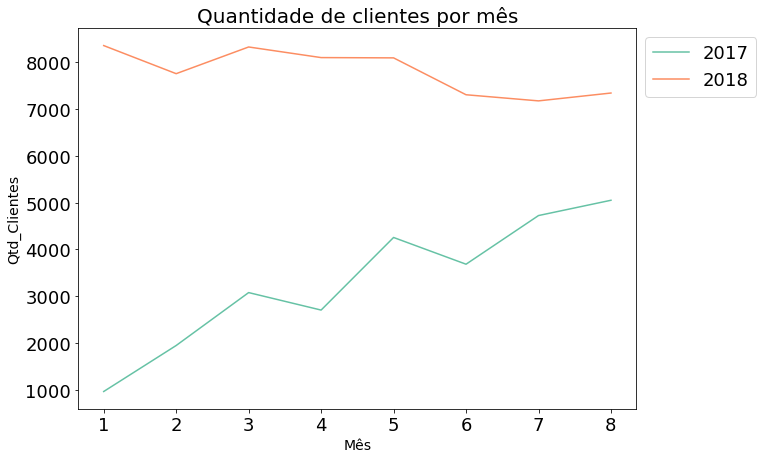

In [298]:
print('O desvio padrão é ',vendas_mesano['ano_compra'].std())
plt.figure(figsize=(10,7))
sns.lineplot(x="mes_compra", y="id_cliente", hue='ano_compra',palette="Set2",
             data=vendas_mesano)
plt.title("Quantidade de clientes por mês", fontsize=20)
plt.xlabel("Mês",fontsize=14)
plt.ylabel("Qtd_Clientes",fontsize=14)
plt.legend(bbox_to_anchor=(1.0, 1), loc=2);



Os gráficos acima demonstram que o total arrecadado no período analisado tem um grau de dependência proporcional ao número de compras de novos clientes no e-commerce.
Entretanto, de acordo à teoria de vendas de Kotler, a desvantagem competitiva ocorre quando o lucro da empresa depende da entrada de novos clientes ao invés da fidelização dos mesmos.

Isso ocorre porque a longo prazo existe um número total de capacidade de venda que a empresa pode alcançar gerando assim estagnação no limite de produção. Porém com a fidelização de clientes, isso garante que a empresa obterá lucro constante mensal pela mesma quantidade de clientes já captados.

Clientes satisfeitos se transformam em defensores da marca, ou em outras palavras, verdadeiros “vendedores” e repassam para contatos, familiares e amigos. Isso gera uma economia de recursos que seriam gastos em marketing e que poderá ser investida em outras prioridades.

Reter clientes na empresa proporciona benefícios no médio e longo prazo. Portanto, o problema que visamos resolver com esta análise é fazer uma segmentação de clientes para que possamos definir estratégias personalizadas para fidelizar cada grupo de clientes.

## Segmentação de Clientes - Método RFM

Existe um problema de negócio que é enfrentado pela maioria das empresas, que é a baixa taxa de conversão de vendas para os seus produtos. 
Os clientes estão em diferentes momentos da vida, e tem necessidades diferentes. Para otimizar a comunicação com o público de maneira personalizada e mais assertiva, uma das estratégias que a ciência de dados utiliza é a segmentação de clientes.


Para a segmentação de clientes, será utilizado o poderoso modelo chamado RFM, que se baseia nos atributos a seguir:
- Recência : Tempo desde a última compra do cliente
- Frequência : Quantidade de compras que o cliente fez
- Monetização : Total gasto por este cliente


In [299]:
data['monetary']=data['preço']
data.drop(['preço'],axis=1,inplace=True)

In [300]:
data.rename(columns={'id_cliente': 'id_cliente'}, inplace = True)
data.rename(columns={'recencia': 'recency'}, inplace = True)
data.rename(columns={'frequencia': 'frequency'}, inplace = True)
data.head()


id_pedido status_pedido  dia_compra  mes_compra  \
0  e481f51cbdc54678b7cc49136f2d6af7     delivered           2          10   
1  e481f51cbdc54678b7cc49136f2d6af7     delivered           2          10   
2  e481f51cbdc54678b7cc49136f2d6af7     delivered           2          10   
3  53cdb2fc8bc7dce0b6741e2150273451     delivered          24           7   
4  47770eb9100c2d0c44946d9cf07ec65d     delivered           8           8   

   ano_compra dia_semana_compra mes_e_ano_compra data_compra hora_compra  \
0        2017               seg          10-2017  2017-10-02    12:00:00   
1        2017               seg          10-2017  2017-10-02    12:00:00   
2        2017               seg          10-2017  2017-10-02    12:00:00   
3        2018               ter          07-2018  2018-07-24    18:00:00   
4        2018               qua          08-2018  2018-08-08    06:00:00   

  tipo_pagamento  ...  nota                        id_cliente  \
0    credit_card  ...   4.0  9ef432eb6251297304e76186b10a928d   
1        voucher  ...   4.0  9ef432eb6251297304e76186b10a928d   
2        voucher  ...   4.0  9ef432eb6251297304e76186b10a928d   
3         boleto  ...   4.0  b0830fb4747a6c6d20dea0b8c802d7ef   
4    credit_card  ...   5.0  41ce2a54c0b03bf3443c3d931a367089   

                 customer_unique_id  cidade_cliente estado_cliente  \
0  7c396fd4830fd04220f754e42b4e5bff       sao paulo             SP   
1  7c396fd4830fd04220f754e42b4e5bff       sao paulo             SP   
2  7c396fd4830fd04220f754e42b4e5bff       sao paulo             SP   
3  af07308b275d755c9edb36a90c618231       barreiras             BA   
4  3a653a41f6f9fc3d2a113cf8398680e8      vianopolis             GO   

  regiao_cliente  recency  frequency  qtd_itens monetary  
0        Sudeste    112.0     129.90          1    29.99  
1        Sudeste    115.0      18.90          1    29.99  
2        Sudeste    538.0      69.00          1    29.99  
3       Nordeste    322.0      25.99          1   118.70  
4   Centro-Oeste    289.0     180.00          1   159.90  

[5 rows x 28 columns]

In [301]:
recorrencia.head()

id_cliente  recencia  frequencia  valor_gasto
0  0000366f3b9a7992bf8c76cfdf3221e2       112           1       129.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f       115           1        18.90
2  0000f46a3911fa3c0805444483337064       538           1        69.00
3  0000f6ccb0745a6a4b88665a16c9f078       322           1        25.99
4  0004aac84e0df4da2b147fca70cf8255       289           1       180.00

count    93260.000000
mean       238.471445
std        152.532331
min          1.000000
25%        115.000000
50%        220.000000
75%        347.000000
max        696.000000
Name: recencia, dtype: float64


Text(0.5, 0, 'Recência')

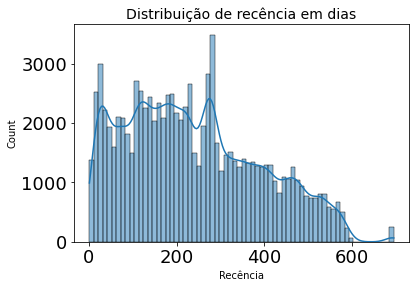

In [302]:
print(recorrencia['recencia'].describe())
sns.histplot(x='recencia', data=recorrencia, kde=True, palette='Set2')
plt.title('Distribuição de recência em dias',fontsize=14)
plt.ylabel('Count',fontsize=10)
plt.xlabel('Recência',fontsize=10)

count    93260.000000
mean       130.523839
std        183.512239
min          0.850000
25%         44.900000
50%         80.000000
75%        148.000000
max       3459.000000
Name: valor_gasto, dtype: float64


Text(0.5, 0, 'valor Gasto')

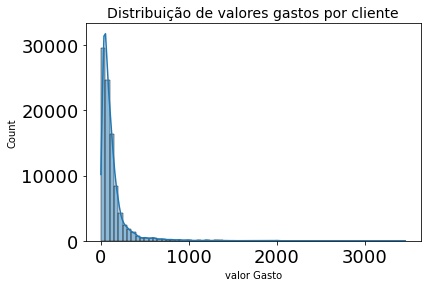

In [303]:
print(recorrencia['valor_gasto'].describe())
sns.histplot(x='valor_gasto', data=recorrencia, kde=True, palette='Set2',bins=70)
plt.title('Distribuição de valores gastos por cliente',fontsize=14)
plt.ylabel('Count',fontsize=10)
plt.xlabel('valor Gasto',fontsize=10)
#Fazer scatter

In [304]:
df = recorrencia

In [305]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96378 entries, 0 to 96377
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id_cliente            96378 non-null  object 
 1   qtd_parcelas          96378 non-null  float64
 2   dif_previsao_entrega  96378 non-null  int64  
 3   nota                  96378 non-null  float64
 4   valor_frete           96378 non-null  float64
 5   recencia              78316 non-null  float64
 6   frequencia            78316 non-null  float64
 7   preço                 96378 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 5.9+ MB


In [306]:
df.head()

id_cliente  recencia  frequencia  valor_gasto
0  0000366f3b9a7992bf8c76cfdf3221e2       112           1       129.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f       115           1        18.90
2  0000f46a3911fa3c0805444483337064       538           1        69.00
3  0000f6ccb0745a6a4b88665a16c9f078       322           1        25.99
4  0004aac84e0df4da2b147fca70cf8255       289           1       180.00

In [307]:
def get_segment(data):
  mean_fm = (data['F'] + data['M']) / 2
  if (data['R'] >= 4 and data['R'] <= 5) and (mean_fm >= 4 and mean_fm <= 5):
    return 'Champions'
  if (data['R'] >= 2 and data['R'] <= 5) and (mean_fm >= 3 and mean_fm <= 5):
      return 'Loyal Customers'
  if (data['R'] >= 3 and data['R'] <= 5) and (mean_fm >= 1 and mean_fm <= 3):
      return 'Potential Loyslist'
  if (data['R'] >= 4 and data['R'] <= 5) and (mean_fm >= 0 and mean_fm <= 1):
      return 'New Customers'
  if (data['R'] >= 3 and data['R'] <= 4) and (mean_fm >= 0 and mean_fm <= 1):
      return 'Promising'
  if (data['R'] >= 2 and data['R'] <= 3) and (mean_fm >= 2 and mean_fm <= 3):
      return 'Customer Needing Attention'
  if (data['R'] >= 2 and data['R'] <= 3) and (mean_fm >= 0 and mean_fm <= 2):
      return 'About to Sleep'
  if (data['R'] >= 0 and data['R'] <= 2) and (mean_fm >= 2 and mean_fm <= 5):
      return 'At Risk'
  if (data['R'] >= 0 and data['R'] <= 1) and (mean_fm >= 4 and mean_fm <= 5):
      return "Can't Lose Then"
  if (data['R'] >= 1 and data['R'] <= 2) and (mean_fm >= 1 and mean_fm <= 2):
      return 'Hibernating'
  return 'Lost'

#Clusterização - Parte 2

Agrupamento Manual

In [308]:
recencia = recorrencia.iloc[:,1].values
frequencia = recorrencia.iloc[:,2].values
valor_gasto = recorrencia.iloc[:,3].values

In [309]:
df_cluster = recorrencia[['id_cliente']]

In [310]:
def gerar_cluster(data, n_clusters,df,asc=False):

  data = data.reshape(-1, 1)
#Padronizando os dados
  scaler = StandardScaler()

  data_temp = scaler.fit_transform(data)

  kmeans_df = KMeans(n_clusters=n_clusters, random_state=1)

  rotulos = kmeans_df.fit_predict(data)

  data_temp1 = np.column_stack((df, rotulos))
  data_temp1 = pd.DataFrame(data_temp1)

  return data_temp1



In [311]:
df_recencia = gerar_cluster(recencia,5,df_cluster,)
df_recencia.columns =['id_cliente','R']

df_frequencia = gerar_cluster(frequencia,5,df_cluster)
df_frequencia.columns =['id_cliente','F']

df_valor_gasto = gerar_cluster(valor_gasto,5,df_cluster)
df_valor_gasto.columns =['id_cliente','M']

In [312]:
data_cluster = pd.merge(df_cluster,df_recencia, on='id_cliente',how='left')
data_cluster = pd.merge(data_cluster,df_frequencia, on='id_cliente',how='left')
data_cluster = pd.merge(data_cluster,df_valor_gasto, on='id_cliente',how='left')
data_cluster = pd.merge(data_cluster,recorrencia,on='id_cliente',how='left')
data_cluster.sample(10)

id_cliente  R  F  M  recencia  frequencia  \
25896  46e7ed1ef9223b2026fb4919fc7c7f05  0  0  4       353           1   
19569  357c1205f56093223740cf08ac514bb8  1  0  1       106           1   
3972   0aadcb7d3e14457462008b8d2a02413a  2  0  4       240           1   
57115  9c9db9057b02a4a1eb0d79e7caa1120f  0  0  0       398           1   
40482  6ed77fe77805800ef9aeb22d79a36e93  3  0  0       557           1   
84009  e65a19abd4e4edcb024111af0dd7f048  2  0  0       207           1   
64823  b18f055a3d6a0309ef511b4e97f67e22  4  0  0        56           1   
49876  88e0d24c0b4b092683069c8d9f89ab70  1  0  0       179           1   
81453  df29f47875551e7560d400281cc8bc85  2  0  0       282           1   
17855  30d6fa639215a7101b8c5ade4379ef21  4  0  0        25           1   

       valor_gasto  
25896        136.9  
19569        329.0  
3972         119.9  
57115         69.9  
40482         39.9  
84009        109.9  
64823         65.0  
49876         52.9  
81453         89.9  
17855        109.9

In [313]:
data_cluster['R'] = data_cluster['R'].astype('int64')
data_cluster['F'] = data_cluster['F'].astype('int64')
data_cluster['M'] = data_cluster['M'].astype('int64')

In [314]:
grupo = data_cluster.groupby('R')['recencia'].describe().reset_index()
grupo = grupo.sort_values(by=grupo.columns[0],ascending=True)
grupo

R    count        mean        std    min    25%    50%    75%    max
0  0  15374.0  379.698192  35.522775  321.0  349.0  379.0  409.0  446.0
1  1  24285.0  152.724068  30.910986  101.0  125.0  153.0  180.0  206.0
2  2  22490.0  260.862872  31.395501  207.0  232.0  265.0  282.0  320.0
3  3  11472.0  511.995293  48.723797  447.0  472.0  505.5  542.0  696.0
4  4  19639.0   48.528286  27.154203    1.0   25.0   44.0   72.0  100.0

In [315]:
#Ordem correta de R 4-1-2-0-3

data_cluster['R']=data_cluster['R'].replace([4], 5)
data_cluster['R']=data_cluster['R'].replace([1], 4)
data_cluster['R']=data_cluster['R'].replace([2], 8)
data_cluster['R']=data_cluster['R'].replace([0], 2)
data_cluster['R']=data_cluster['R'].replace([3], 1)
data_cluster['R']=data_cluster['R'].replace([8], 3)
data_cluster['R']

0        4
1        4
2        1
3        2
4        3
        ..
93255    3
93256    3
93257    1
93258    4
93259    1
Name: R, Length: 93260, dtype: int64

In [316]:
#Ordem correta de F 3-4-2-1-0
grupo = data_cluster.groupby('F')['frequencia'].describe().reset_index()
grupo = grupo.sort_values(by=grupo.columns[0],ascending=True)
grupo

F    count      mean       std  min  25%  50%  75%   max
0  0  88364.0  1.000000  0.000000  1.0  1.0  1.0  1.0   1.0
1  1   4309.0  2.000000  0.000000  2.0  2.0  2.0  2.0   2.0
2  2    457.0  3.000000  0.000000  3.0  3.0  3.0  3.0   3.0
3  3     19.0  7.157895  2.192491  6.0  6.0  6.0  7.5  15.0
4  4    111.0  4.189189  0.393435  4.0  4.0  4.0  4.0   5.0

In [317]:
data_cluster['F']=data_cluster['F'].replace([3], 5)
data_cluster['F']=data_cluster['F'].replace([2], 3)
data_cluster['F']=data_cluster['F'].replace([1], 2)
data_cluster['F']=data_cluster['F'].replace([0], 1)
data_cluster['F']

0        1
1        1
2        1
3        1
4        1
        ..
93255    1
93256    1
93257    1
93258    1
93259    1
Name: F, Length: 93260, dtype: int64

In [318]:
grupo = data_cluster.groupby('M')['valor_gasto'].describe().reset_index()
grupo = grupo.sort_values(by=grupo.columns[0],ascending=True)
grupo

M    count         mean         std      min      25%      50%     75%  \
0  0  59967.0    56.028356   28.267355     0.85    30.21    52.00    79.0   
1  1   5798.0   412.025202  102.636975   291.50   329.90   379.99   489.0   
2  2    332.0  1910.509910  400.603440  1420.00  1599.00  1849.95  2090.0   
3  3   1565.0   920.016486  207.088290   666.80   749.00   859.00  1054.0   
4  4  25598.0   169.925915   45.134650   113.23   130.00   159.00   199.0   

       max  
0   113.10  
1   665.56  
2  3459.00  
3  1400.00  
4   291.00

In [319]:
data_cluster['M']=data_cluster['M'].replace([2], 5)
data_cluster['M']=data_cluster['M'].replace([4], 2)
data_cluster['M']=data_cluster['M'].replace([3], 4)
data_cluster['M']=data_cluster['M'].replace([1], 3)
data_cluster['M']=data_cluster['M'].replace([0], 1)
data_cluster['M']

0        2
1        1
2        1
3        1
4        2
        ..
93255    2
93256    1
93257    1
93258    2
93259    1
Name: M, Length: 93260, dtype: int64

In [320]:
data_cluster['segmento'] = data_cluster.apply(get_segment,axis=1)

In [321]:
data_cluster

id_cliente  R  F  M  recencia  frequencia  \
0      0000366f3b9a7992bf8c76cfdf3221e2  4  1  2       112           1   
1      0000b849f77a49e4a4ce2b2a4ca5be3f  4  1  1       115           1   
2      0000f46a3911fa3c0805444483337064  1  1  1       538           1   
3      0000f6ccb0745a6a4b88665a16c9f078  2  1  1       322           1   
4      0004aac84e0df4da2b147fca70cf8255  3  1  2       289           1   
...                                 ... .. .. ..       ...         ...   
93255  fffbf87b7a1a6fa8b03f081c5f51a201  3  1  2       246           1   
93256  fffea47cd6d3cc0a88bd621562a9d061  3  1  1       263           1   
93257  ffff371b4d645b6ecea244b27531430a  1  1  1       569           1   
93258  ffff5962728ec6157033ef9805bacc48  4  1  2       120           1   
93259  ffffd2657e2aad2907e67c3e9daecbeb  1  1  1       485           1   

       valor_gasto            segmento  
0           129.90  Potential Loyslist  
1            18.90  Potential Loyslist  
2            69.00         Hibernating  
3            25.99      About to Sleep  
4           180.00  Potential Loyslist  
...            ...                 ...  
93255       149.00  Potential Loyslist  
93256        64.89  Potential Loyslist  
93257        89.90         Hibernating  
93258       115.00  Potential Loyslist  
93259        56.99         Hibernating  

[93260 rows x 8 columns]

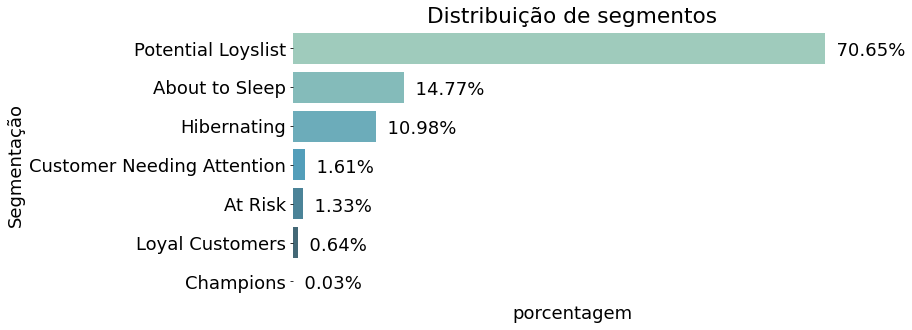

In [322]:
plt.figure(figsize=(10,5))
percentage = (data_cluster['segmento'].value_counts(normalize=True)* 100).reset_index(name='porcentagem')
g = sns.barplot(x=percentage['porcentagem'],y=percentage['index'], data=percentage,palette="GnBu_d")
sns.despine(bottom = True, left = True)
for i, v in enumerate(percentage['porcentagem']):
    g.text(v,i+0.20,"  {:.2f}".format(v)+"%", color='black', ha="left")
g.set_ylabel('Segmentação')
g.set(xticks=[])
plt.title('Distribuição de segmentos')
plt.show()

In [323]:
segmentwise = data_cluster.groupby('segmento').agg(RecencyMean = ('recencia', 'mean'),
                                          FrequencyMean = ('frequencia', 'mean'),
                                          MonetaryMean = ('valor_gasto', 'mean'),
                                          GroupSize = ('recencia', 'size'))
segmentwise


RecencyMean  FrequencyMean  MonetaryMean  \
segmento                                                               
About to Sleep               380.046471       1.017427     87.480250   
At Risk                      515.106796       1.283981    519.332710   
Champions                     95.269231       5.923077    809.211923   
Customer Needing Attention   376.891188       1.357810    446.865454   
Hibernating                  511.619578       1.017878     85.932666   
Loyal Customers              191.026622       2.139767   1194.498419   
Potential Loyslist           158.600871       1.054196    121.989887   

                            GroupSize  
segmento                               
About to Sleep                  13772  
At Risk                          1236  
Champions                          26  
Customer Needing Attention       1498  
Hibernating                     10236  
Loyal Customers                   601  
Potential Loyslist              65891

In [324]:
data.rename(columns={'id_cliente': 'id'}, inplace = True)
data.rename(columns={'customer_unique_id': 'id_cliente'}, inplace = True)


In [325]:
data['data_compra']=data['data_compra'].astype('datetime64')

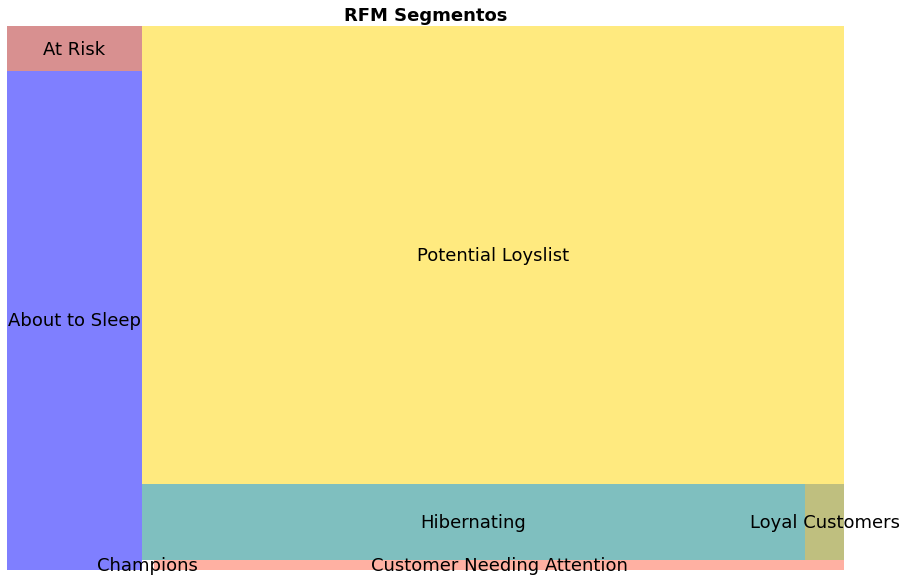

In [326]:
font = {'family' : 'Dejavu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)


fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(15, 10)
squarify.plot(sizes = segmentwise['GroupSize'], 
              label = segmentwise.index,
              color = ['blue','firebrick','white', 'tomato', 'teal', 'olive', 'gold'],
              alpha = 0.5)
plt.title("RFM Segmentos",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

In [327]:
df_merg=data.groupby(['id_cliente','regiao_cliente']).agg({'id': np.size}).reset_index()
df_merg=df_merg.drop_duplicates(subset='id_cliente', keep='last')
#['id_cliente'].nunique()
df_merg.head()

id_cliente regiao_cliente  id
0  0000366f3b9a7992bf8c76cfdf3221e2        Sudeste   1
1  0000b849f77a49e4a4ce2b2a4ca5be3f        Sudeste   1
2  0000f46a3911fa3c0805444483337064            Sul   1
3  0000f6ccb0745a6a4b88665a16c9f078          Norte   1
4  0004aac84e0df4da2b147fca70cf8255        Sudeste   1

In [328]:
data_final=pd.merge(data_cluster,df_merg,on='id_cliente',how='left')

data_final.sample(10)

id_cliente  R  F  M  recencia  frequencia  \
46449  7f4b081170dea178bbad9ece0a45e0f4  3  1  1       313           1   
73760  ca2c4eba154785f0287fd609d67dfb9e  2  1  1       386           1   
91742  fbc80b4ae95e3dcd2cbb507ac84c1b99  3  1  2       308           1   
88887  f3e06e60599257ec0a10ef53641c7806  2  1  3       423           1   
73986  caccd68dd4f7eb6c51f70c91ae9d7dc1  4  1  2       143           1   
11016  1defe0913f512f19056b668156476990  5  1  1        32           1   
33163  5ab603cce283352d94cc28dad9bb9570  5  1  1        20           1   
91509  fb22cab15a8656528c3d36648860c9bc  3  1  1       282           1   
88697  f35b5c2b6e628290912f97deb457c38b  4  1  1       191           1   
86565  ed5687469a409b581773136a1c05b99b  3  1  1       279           1   

       valor_gasto                    segmento regiao_cliente  id  
46449        13.99          Potential Loyslist        Sudeste   1  
73760        59.90              About to Sleep   Centro-Oeste   1  
91742       116.99          Potential Loyslist        Sudeste   1  
88887       329.90  Customer Needing Attention        Sudeste   1  
73986       254.90          Potential Loyslist   Centro-Oeste   1  
11016        78.00          Potential Loyslist        Sudeste   1  
33163        29.90          Potential Loyslist        Sudeste   1  
91509        99.00          Potential Loyslist        Sudeste   3  
88697        45.90          Potential Loyslist       Nordeste   2  
86565        39.90          Potential Loyslist   Centro-Oeste   1

In [329]:
clientes_seg_regiao=data_final.groupby(['regiao_cliente','segmento']).agg({'valor_gasto': np.mean,'id_cliente':'count'}).reset_index()
clientes_seg_regiao.sample(10)
clientes_seg_regiao.rename(columns={'id_cliente': 'qtd_cli'}, inplace = True)

clientes_seg_sudeste= data_final.loc[data_final['regiao_cliente']=='Sudeste']
clientes_seg_sudeste=clientes_seg_sudeste.sort_values('valor_gasto', ascending=False)


clientes_seg_centroOeste= data_final.loc[data_final['regiao_cliente']=='Centro-Oeste']
clientes_seg_centroOeste=clientes_seg_centroOeste.sort_values('valor_gasto', ascending=False)


clientes_seg_sul= data_final.loc[data_final['regiao_cliente']=='Sul']
clientes_seg_sul=clientes_seg_sul.sort_values('valor_gasto', ascending=False).head(5)


clientes_seg_norte= data_final.loc[data_final['regiao_cliente']=='Norte']
clientes_seg_norte=clientes_seg_norte.sort_values('valor_gasto', ascending=False)


clientes_seg_nordeste= data_final.loc[data_final['regiao_cliente']=='Nordeste']
clientes_seg_nordeste=clientes_seg_nordeste.sort_values('valor_gasto', ascending=False)

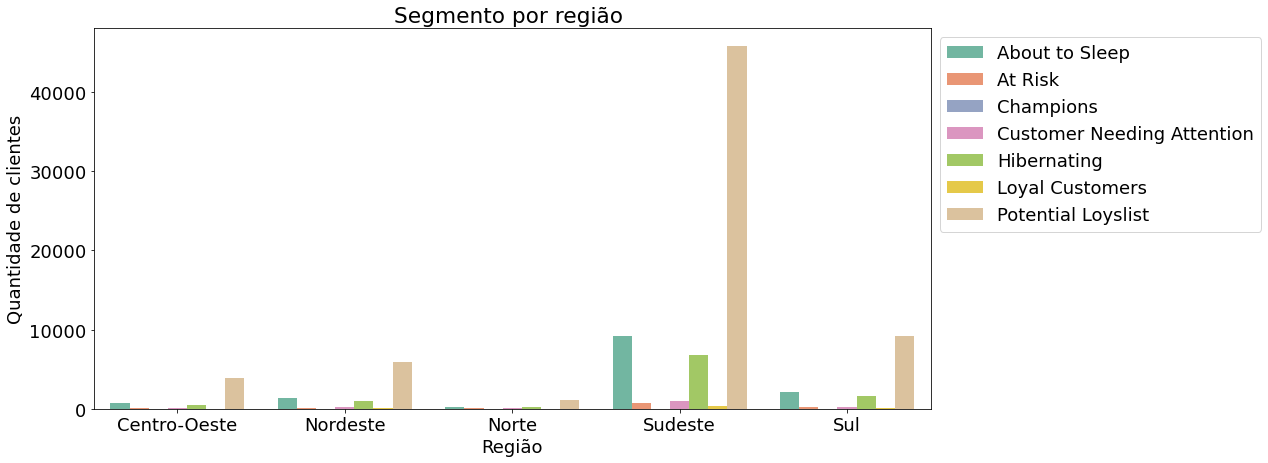

In [330]:

#clientes_seg_regiao= pd.merge(produtos_seg_regiao,data_final,on='id_cliente',how='left')
#pd.concat([produtos_seg_norte, produtos_seg_sul,produtos_seg_nordeste,produtos_seg_sudeste,produtos_seg_centroOeste])
plt.figure(figsize=(15,7))
plt.title('Segmento por região ')
sns.barplot(x="regiao_cliente",y="qtd_cli",hue="segmento",palette="Set2", data=clientes_seg_regiao)
plt.ylabel("Quantidade de clientes")
plt.xlabel("Região")
plt.legend(bbox_to_anchor=(1.0, 1), loc=2);


## Conclusões

#### Vender mais para os mesmos consumidores, receber indicações e ter previsibilidade de receita são vantagens da fidelização de clientes. Portanto, de acordo com a segmentação apresentada, sugerimos algumas estratégias que podem ser abordadas em cada grupo.


### 70,65% Potencial Loylist:
#### Este grupo é composto de compradores recentes, e que tem uma boa média de valor gasto e frequência.
#### É um grupo com muito potencial, pois clientes que tiveram uma experiência positiva recente com a empresa podem se interessar em realizar novas compras.
#### Algumas estratégias que podem ser interessantes
○ Recomendações personalizadas de produtos por exemplo;
○ Oferecer um programa de fidelidade ou vouchers de desconto;
○ Manter estes clientes em potencial engajados com a marca;

### 14,77% About To Sleep:
#### São clientes que, embora não comprem há muito tempo, ainda podem comprar novamente. 
#### Este grupo precisa de atenção, pois é o segundo segmento com mais clientes. É preciso recuperar o interesse destas pessoas na empresa.
#### Algumas estratégias que podem ser interessantes
○ Recomendações de produtos populares e promoções;
○ Comunicações personalizadas e direcionadas ao perfil do cliente;


### 10,98% Hibernating:
#### São clientes que compraram há muito tempo, apenas uma ou poquíssimas vezes e gastaram pouco.
#### Este grupo precisa ser trabalhado para que a empresa volte a ser interessante para que ele seja fidelizado.
#### Algumas estratégias que podem ser interessantes
○ Ofertas de produtos relevantes e bons negócios;
○ Comunicações de envio de ofertas;

### 1,61% Customer Needing Attention:
#### São clientes que compraram recentemente, mas ainda podem ter dúvidas se farão a próxima compra na empresa ou em um concorrente .
#### Este grupo precisa de ações para que ele seja perceba que a empresa pode oferecer as melhores condições e atender a todas suas expectativas.
#### Algumas estratégias que podem ser interessantes
○ Campanhas promocionais por tempo limitado, que causem a sensação de imperdíveis;
○ Mostrar as vantagens que sua empresa oferece;
○ Recomendações de produtos com base em seu comportamento;

### 1,33% At Risk:
#### São clientes que gastam pouco dinheiro e compram com frequência, mas não compram há muito tempo
#### Este grupo mostra uma parcela de clientes que ao longo do tempo perdeu o interesse na empresa. É necessário recuperar a atenção destas empresas
#### Algumas estratégias que podem ser interessantes
○ Envio de comunicações personalizadas e mensagens para se aproximar novamente do cliente;
○ Oferecer bons negócios;

### 0,64% Loyal Customers:
#### São clientes que gastam bem e com frequência
#### Neste grupo se encaixam clientes que já acreditam na empresa. É preciso manter este relacionamento para que ele evolua para uma recência maior, e eles se tornem clientes Champions.
#### Algumas estratégias que podem ser interessantes
○ Comunicação personalizada;
○ Evitar o envio de ofertas em massa genéricas;
○ Ofereça poucos produtos, mas apresente produtos nos quais eles provavelmente tenham interesse;
○ Implementar alguma recompensa para a análise de produtos e reviews para que eles tenham vontade de expressar suas experiências positivas e motivem outros compradores;


### 0,03% Champions:
#### São clientes que compraram recentemente, compram com frequência e gastam muito. Verdadeiros vendedores indiretos da marca, e o objetivo principal deve ser aumentar cada vez mais este grupo.
#### São clientes defensores da marca. É preciso manter este relacionamento para que o cliente continue engajado.
#### Algumas estratégias que podem ser interessantes
○ Ofertas, produtos e descontos especiais para estes clientes para que se sintam valorizados;
○ Evitar o envio de ofertas em massa genéricas;
○ Comunicações personalizadas;
○ Recompensas;
○ Peça opiniões e feedbacks para mostrar que a opinião dele como cliente importa;